In [1]:
#%matplotlib inline

# for seaborn issue:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

Loading the data

In [146]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
len(test)

1459

First view of the data

In [3]:
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [4]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
print train.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [6]:
print test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

In [7]:
len(train)

1460

So we have "MiscFeature" with 51 values, "Fence" with 290, "PoolQC" with 3, "FireplaceQu" with 729 and "Alley" with 107 values, so I will not use this data
The rest of variables have a relative small quantity of Nans, so in principle we will not use the features: MiscFeature, Fence, PollQC, FireplaceQu and Alley.
The following features have almost all the values without Nans, then we will look at them to decide if there are relevant or not:
MSZoning, LotFrontage, Utilities, Exterior1st, Exterior2st, MasVnrType, MasVnrArea, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinSF2, BsmtFinType2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath, KitchenQual, Functional, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, SaleType

In [43]:
numerical_columns=train.describe().columns
numerical_columns
print len(numerical_columns)

38


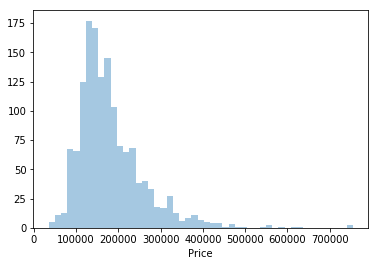

In [14]:
sns.distplot(train["SalePrice"].dropna().values, kde=False,axlabel="Price")
plt.show()

In [16]:
tab=pd.crosstab(train["SalePrice"],train["MSSubClass"])
print tab

MSSubClass  20   30   40   45   50   60   70   75   80   85   90   120  160  \
SalePrice                                                                     
34900         0    1    0    0    0    0    0    0    0    0    0    0    0   
35311         1    0    0    0    0    0    0    0    0    0    0    0    0   
37900         0    0    0    0    1    0    0    0    0    0    0    0    0   
39300         1    0    0    0    0    0    0    0    0    0    0    0    0   
40000         0    0    0    0    0    0    1    0    0    0    0    0    0   
52000         0    1    0    0    0    0    0    0    0    0    0    0    0   
52500         0    1    0    0    0    0    0    0    0    0    0    0    0   
55000         0    1    0    0    0    0    0    0    0    0    0    0    0   
55993         1    0    0    0    0    0    0    0    0    0    0    0    0   
58500         0    1    0    0    0    0    0    0    0    0    0    0    0   
60000         1    2    0    0    0    0    0    0  

In [48]:
train_dummies=pd.get_dummies(train[train.columns])

In [50]:
#train_dummies.head(10)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0
5,6,50,85.0,14115,5,5,1993,1995,0.0,732,...,0,0,0,1,0,0,0,0,1,0
6,7,20,75.0,10084,8,5,2004,2005,186.0,1369,...,0,0,0,1,0,0,0,0,1,0
7,8,60,NaN,10382,7,6,1973,1973,240.0,859,...,0,0,0,1,0,0,0,0,1,0
8,9,50,51.0,6120,7,5,1931,1950,0.0,0,...,0,0,0,1,1,0,0,0,0,0
9,10,190,50.0,7420,5,6,1939,1950,0.0,851,...,0,0,0,1,0,0,0,0,1,0


In [52]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train_numeric=train.apply(le.fit_transform)

In [55]:
train_numeric.head(10)
#train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,5,3,36,327,1,0,3,3,0,...,0,0,0,0,0,1,2,8,4,412
1,1,0,3,51,498,1,946,3,3,0,...,0,973,1041,959,0,4,1,8,4,339
2,2,5,3,39,702,1,945,0,3,0,...,0,972,1042,958,0,8,2,8,4,442
3,3,6,3,31,489,1,944,0,3,0,...,0,971,1043,957,0,1,0,8,0,194
4,4,5,3,55,925,1,943,0,3,0,...,0,970,1054,956,0,11,2,8,4,494
5,5,4,3,56,915,1,942,0,3,0,...,0,969,1181,1408,10,9,3,8,4,203
6,6,0,3,46,552,1,941,3,3,0,...,0,968,1053,955,0,7,1,8,4,573
7,7,5,3,141,593,1,940,0,3,0,...,0,967,1024,1408,2,10,3,8,4,390
8,8,4,4,22,138,1,939,3,3,0,...,0,966,1055,954,0,3,2,8,0,151
9,9,14,3,21,222,1,947,3,3,0,...,0,965,1076,953,0,0,2,8,4,113


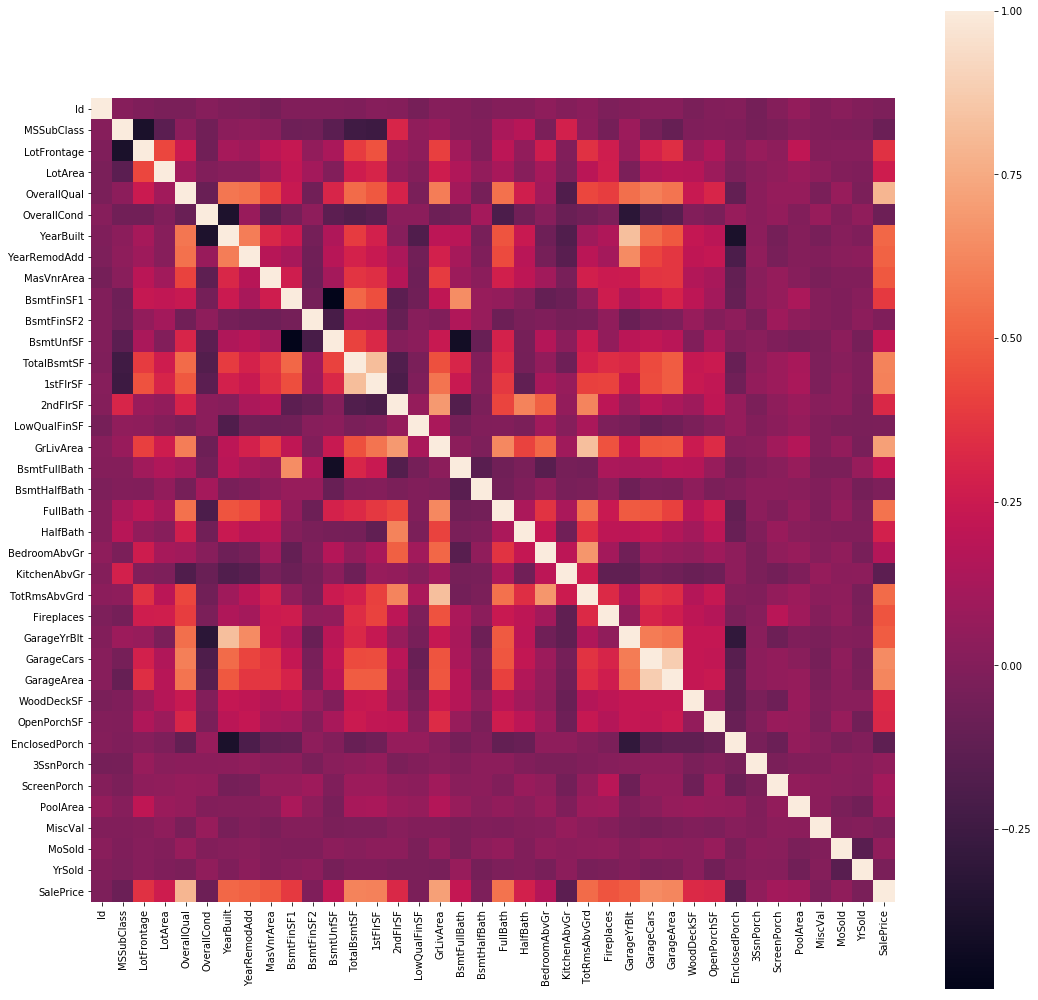

In [25]:
plt.figure(figsize=(18,18))
sns.heatmap(train.drop(["MiscFeature","Fence","PoolQC","FireplaceQu","Alley"],axis=1).corr(), square=True)
plt.show()

Now that we can see how the features correlate let's check the correlations with SalePrice

In [42]:
correlation=train.corr()
correlation_with_target=correlation[["SalePrice"]].drop("SalePrice",axis=0)
correlation_with_target.sort_values(by="SalePrice",ascending=False)

,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


In [44]:
print len(correlation_with_target)

37


In [56]:
train_new=train.drop(["MiscFeature","Fence","PoolQC","FireplaceQu","Alley"],axis=1)

In [82]:
#List of columns with null value
columns_with_nan=train_new.columns[train_new.isnull().any()].tolist()
columns_with_nan
#numerical_columns=train_new.describe().columns
#numerical_columns
#train_new._get_numeric_data()
#train_new.select_dtypes(exclude=['object'])

['LotFrontage',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [77]:
cols=train_new.columns
num_cols=train_new._get_numeric_data().columns
categorical_columns=list(set(cols)-set(num_cols))

In [88]:
cateogircal_with_nan=list(set(categorical_columns).intersection(columns_with_nan))
cateogircal_with_nan

['MasVnrType',
 'GarageType',
 'BsmtCond',
 'GarageQual',
 'GarageFinish',
 'BsmtQual',
 'Electrical',
 'BsmtExposure',
 'BsmtFinType2',
 'BsmtFinType1',
 'GarageCond']

MasVnrType

In [154]:
def plot_things(feature):
    plt.figure(figsize=(10,10))

    #sns.barplot(x=feature,y="SalePrice", hue="OverallQual",data=train_new)
    sns.barplot(x=feature,y="SalePrice",data=train_new)
    plt.show()
    plt.figure(figsize=(10,10))

    sns.countplot(x=feature,data=train_new)
    plt.show()


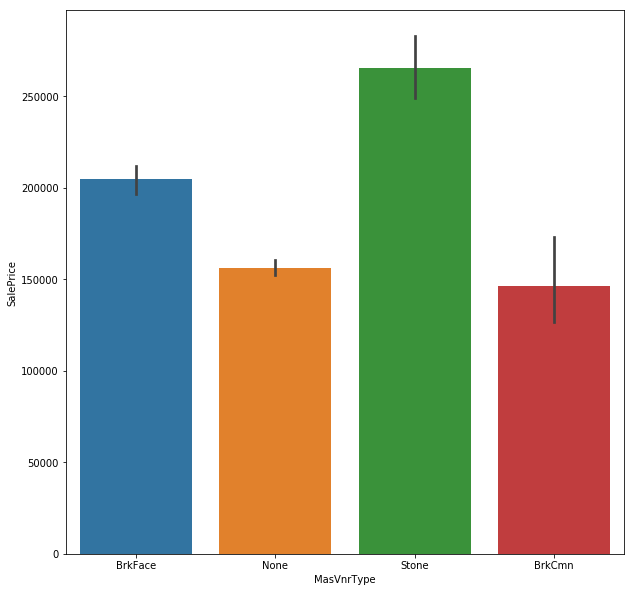

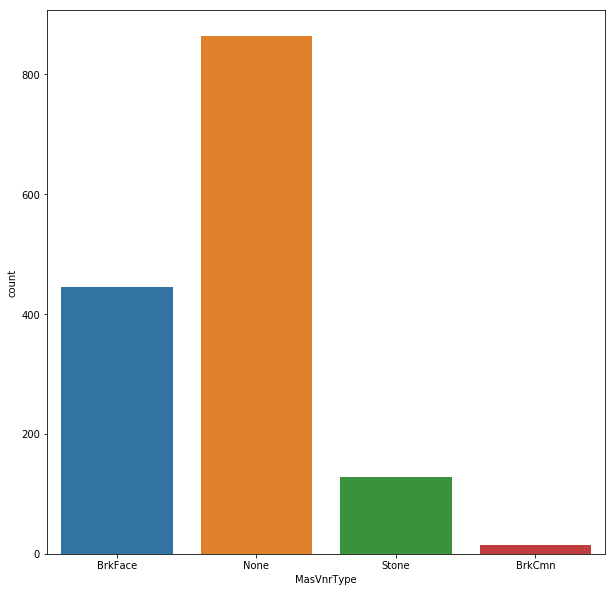

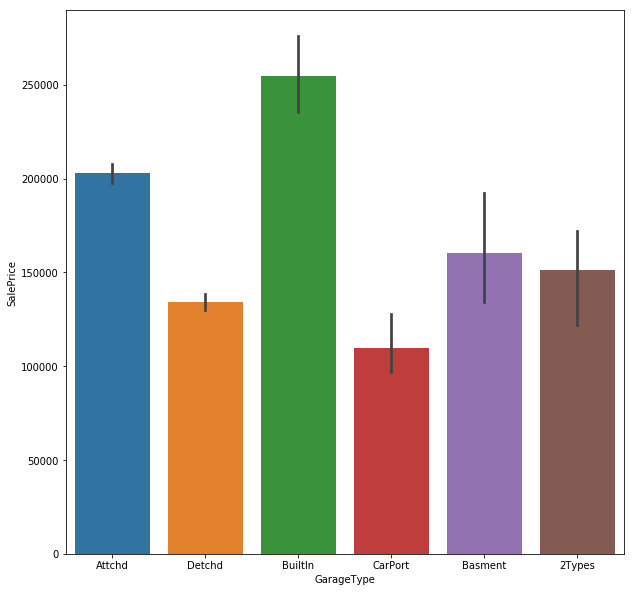

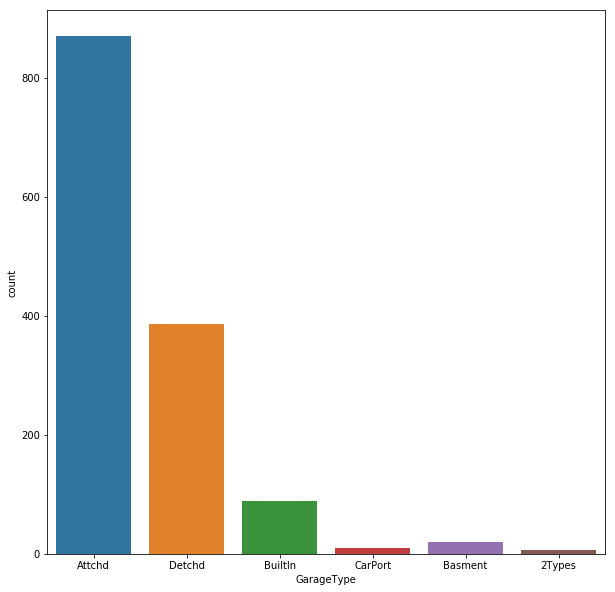

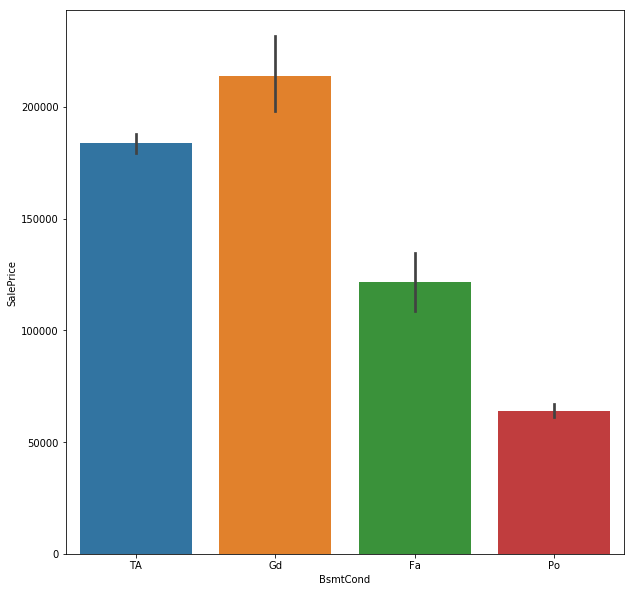

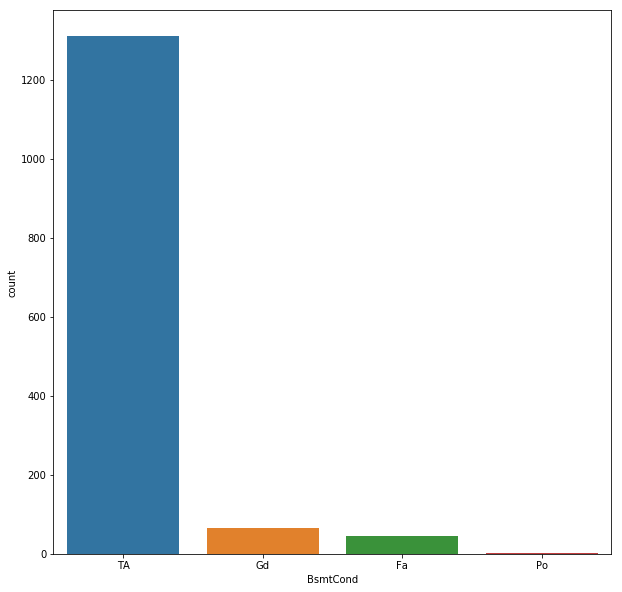

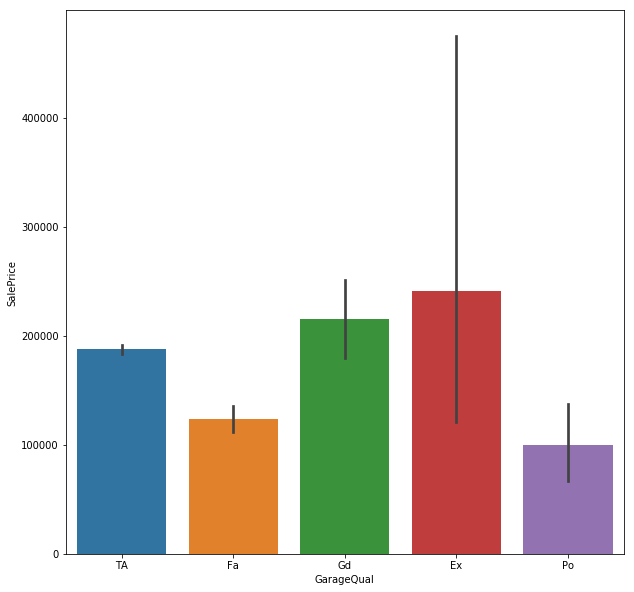

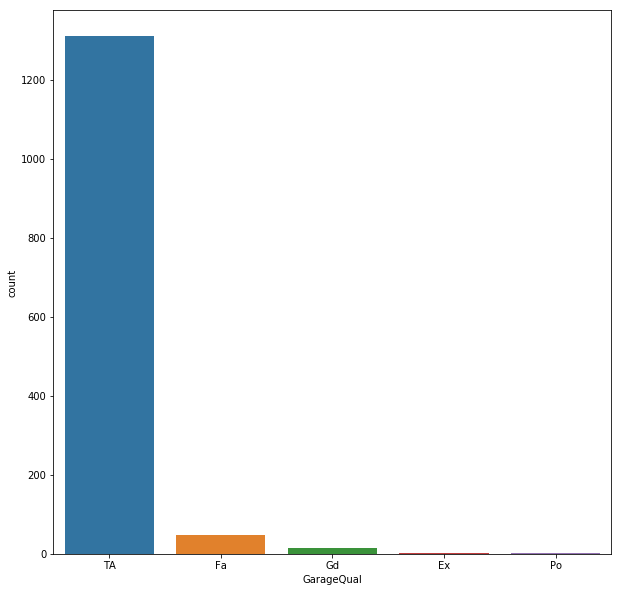

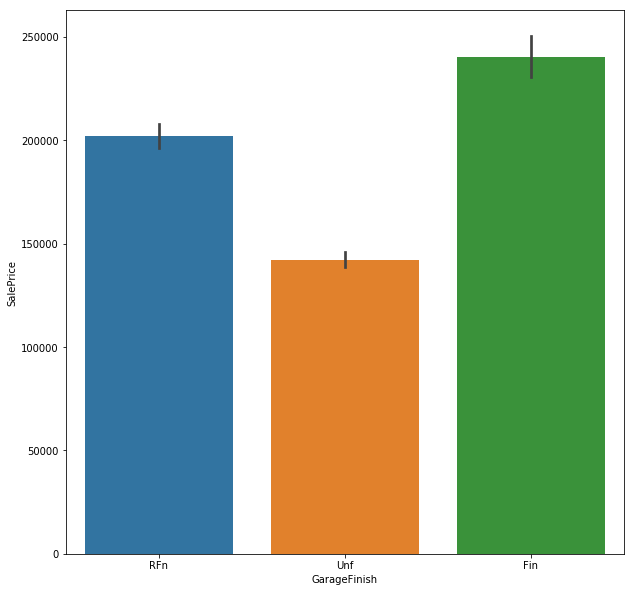

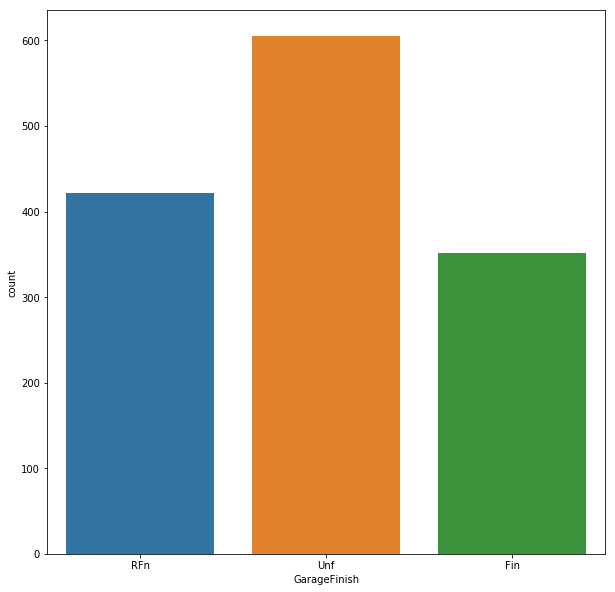

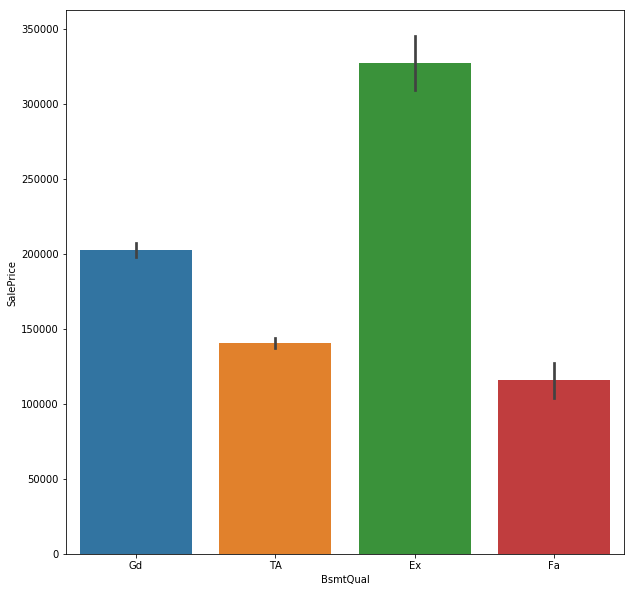

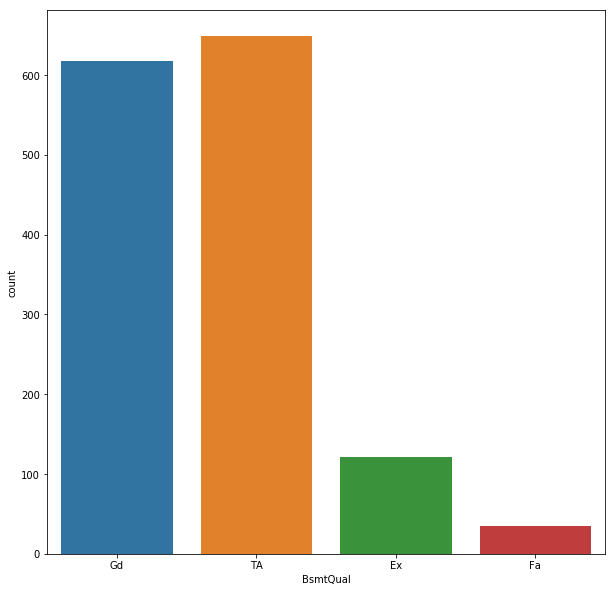

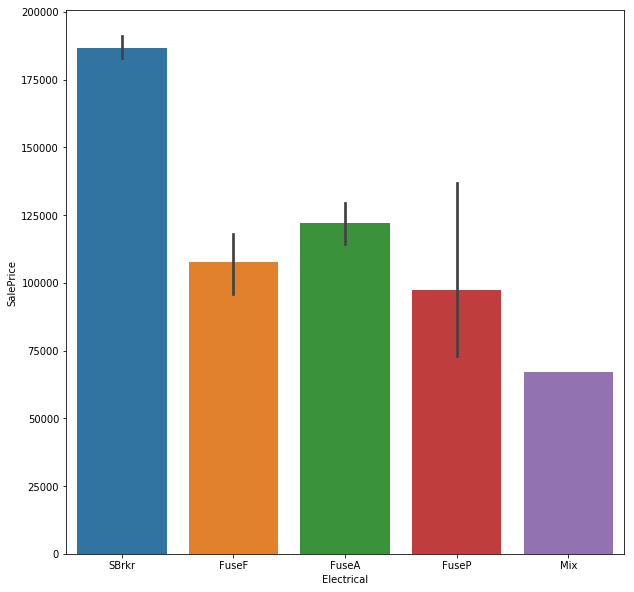

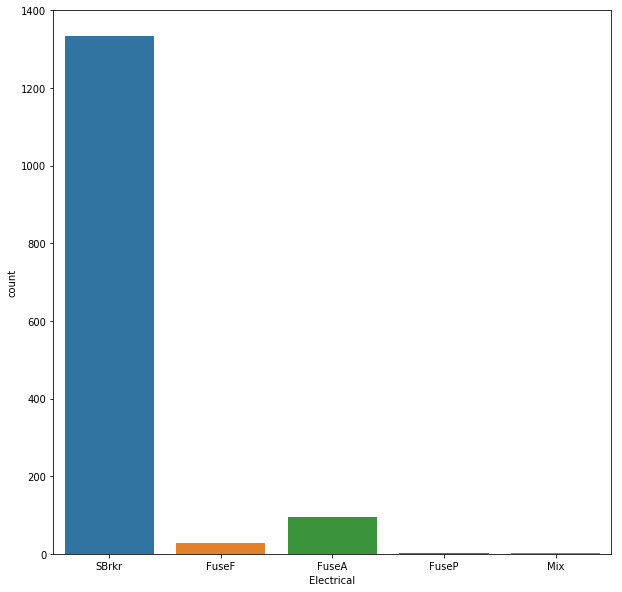

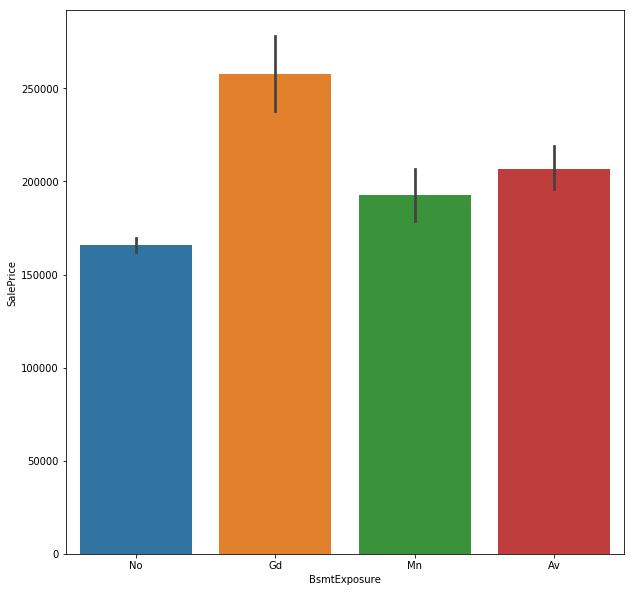

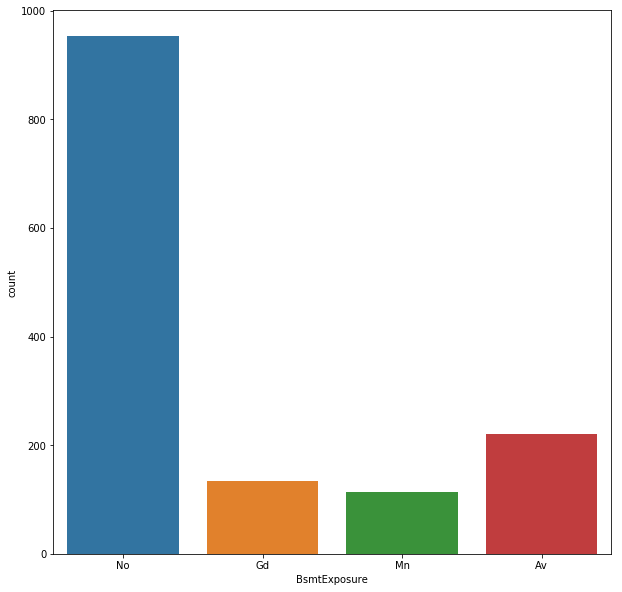

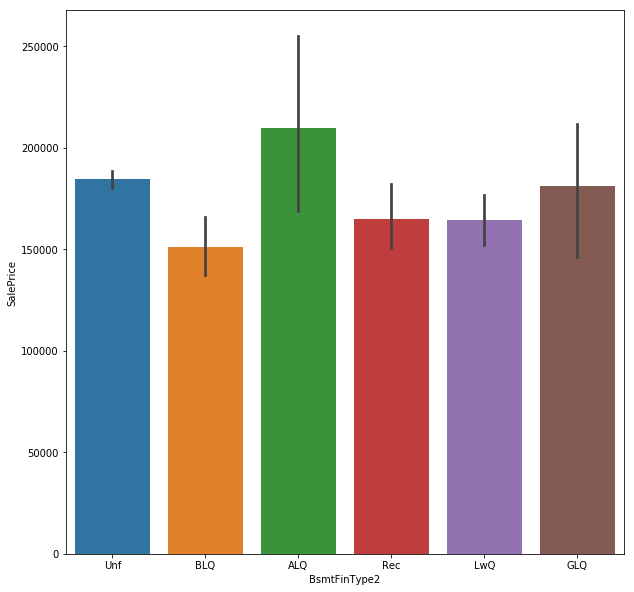

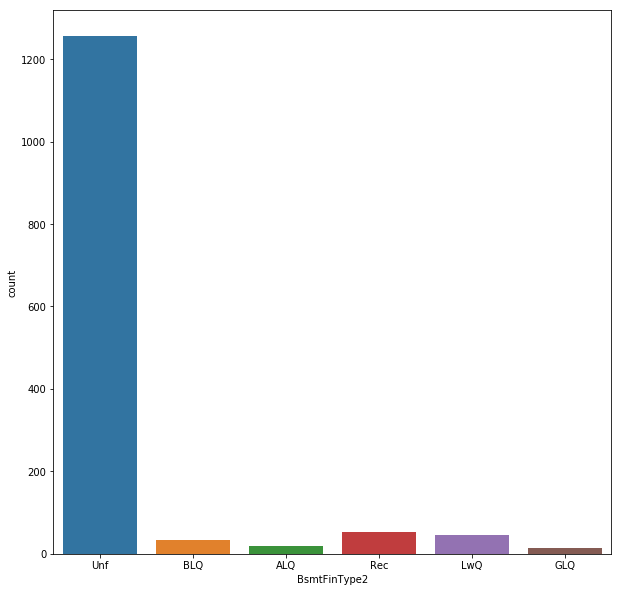

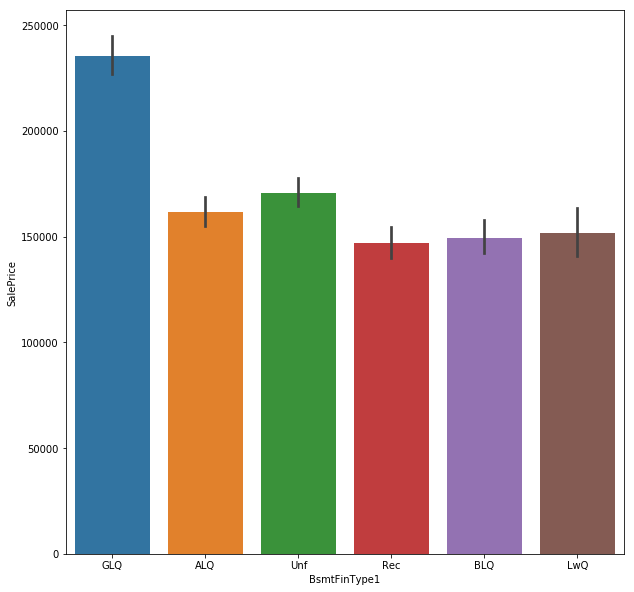

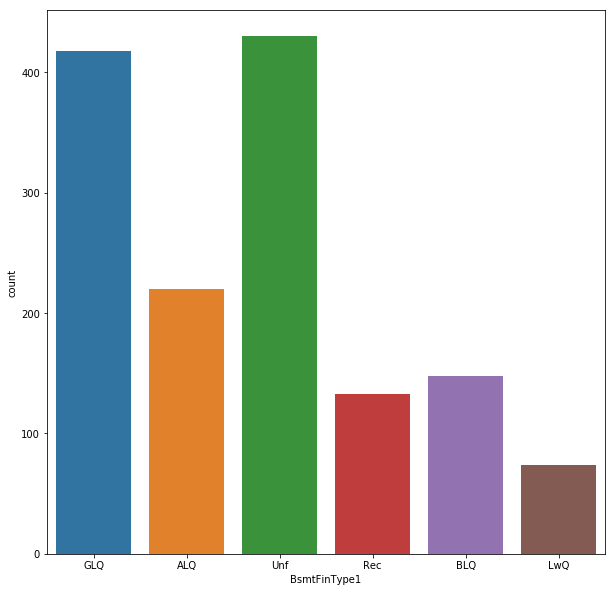

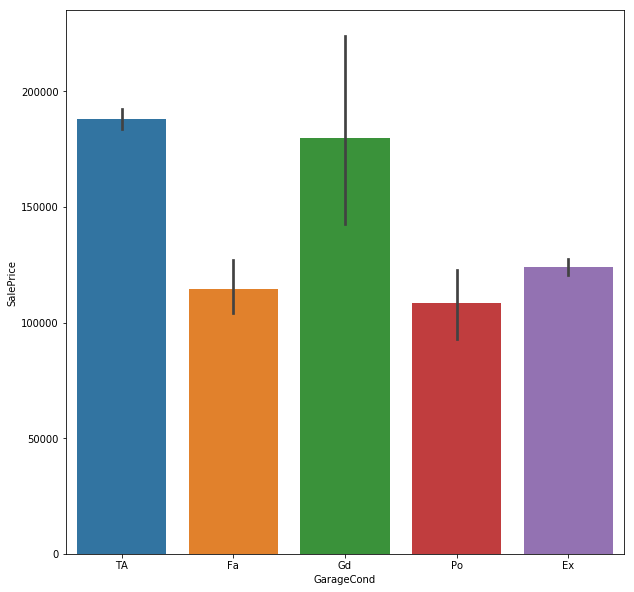

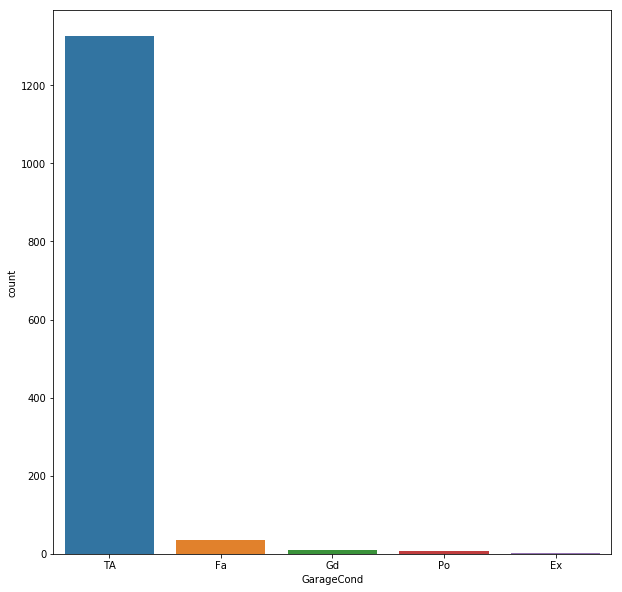

In [155]:
for i in cateogircal_with_nan:
    plot_things(i)

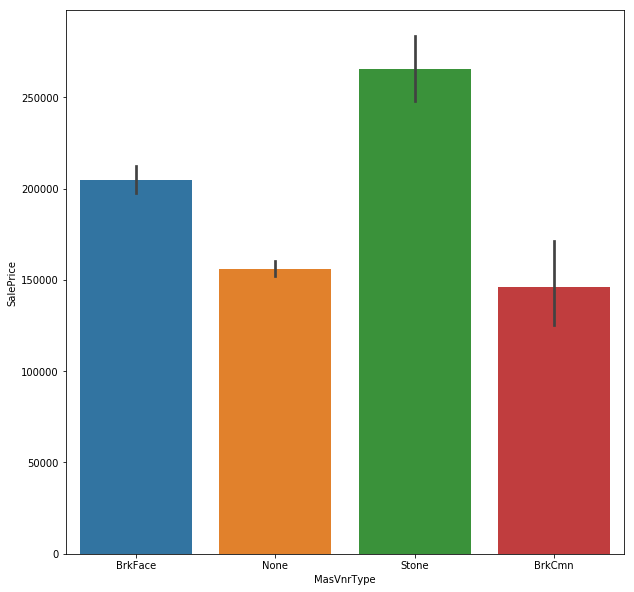

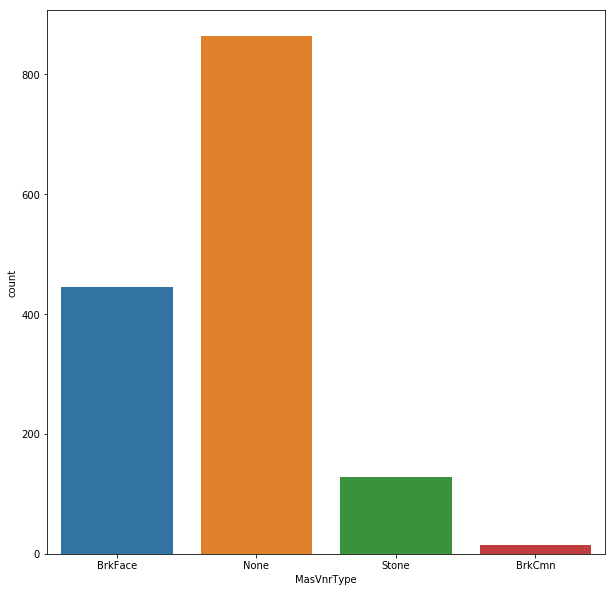

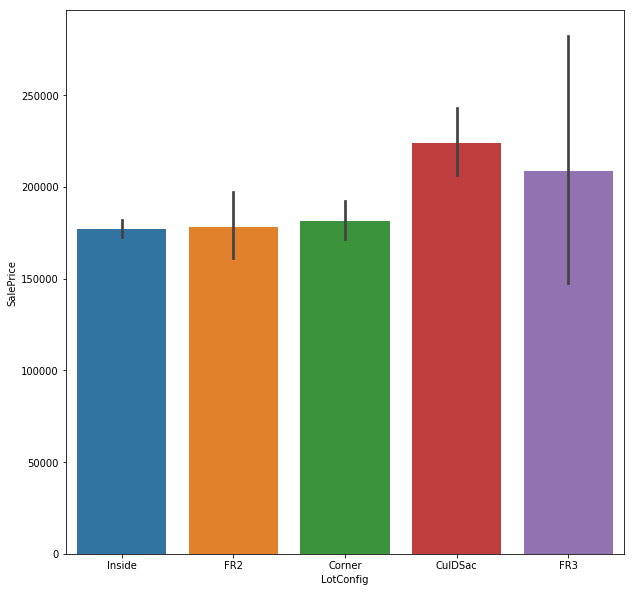

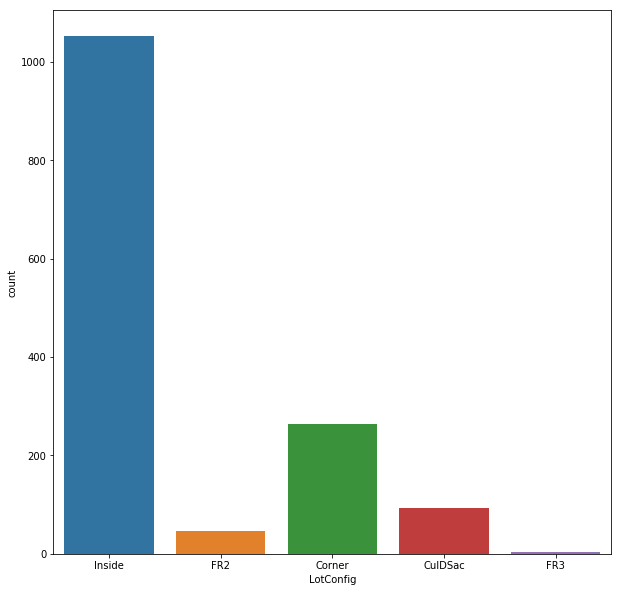

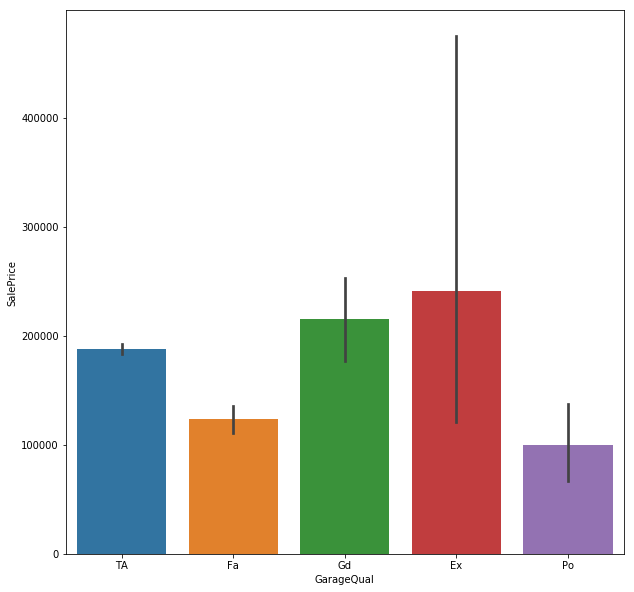

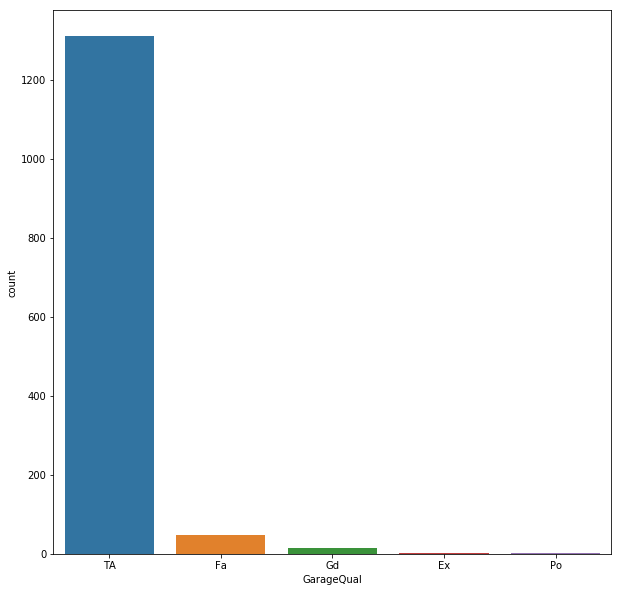

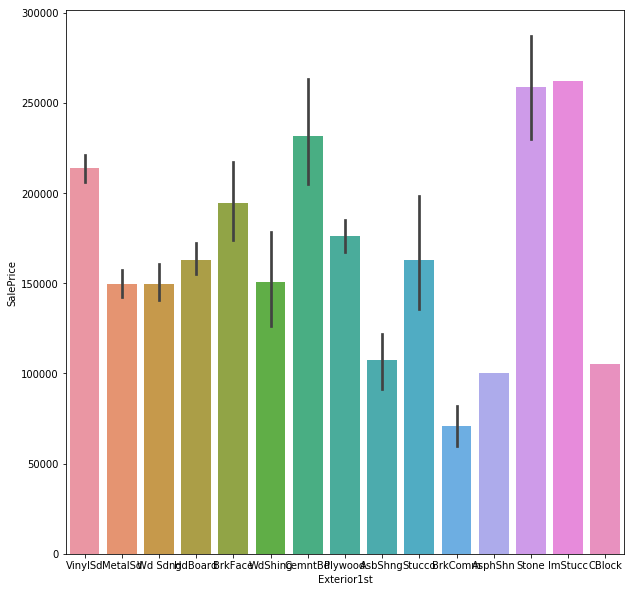

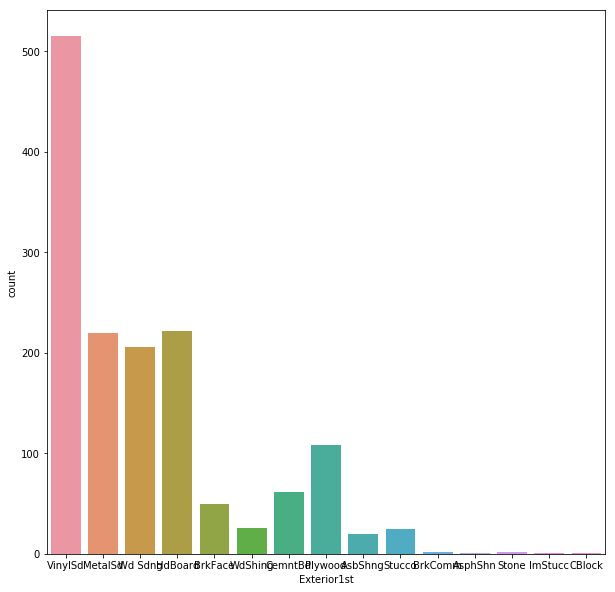

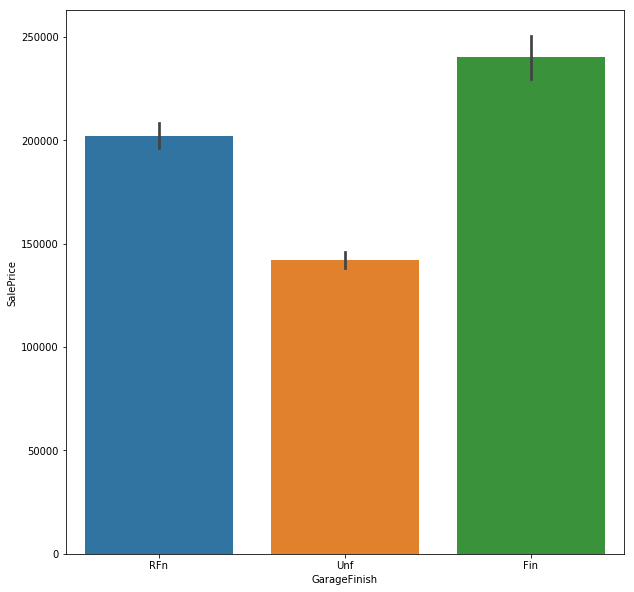

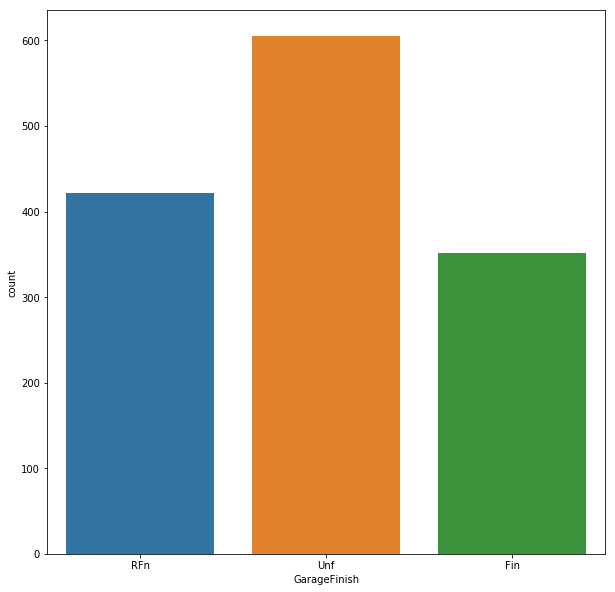

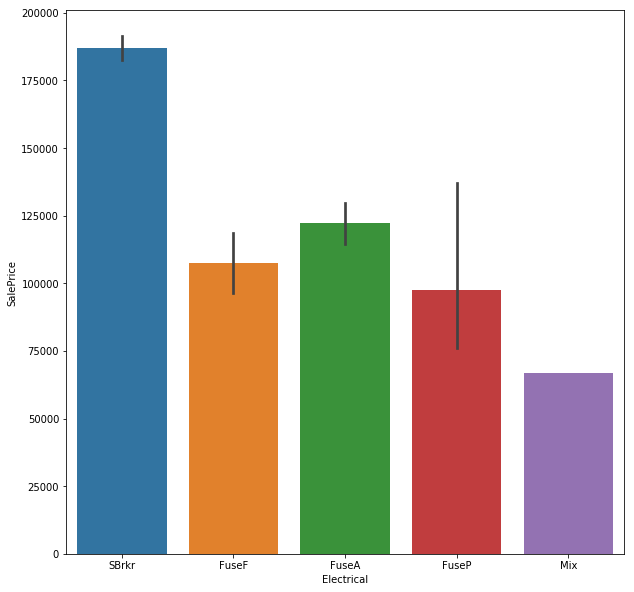

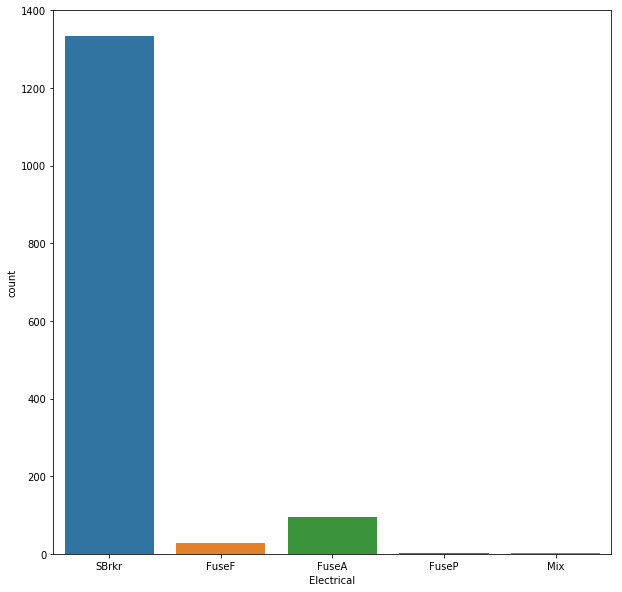

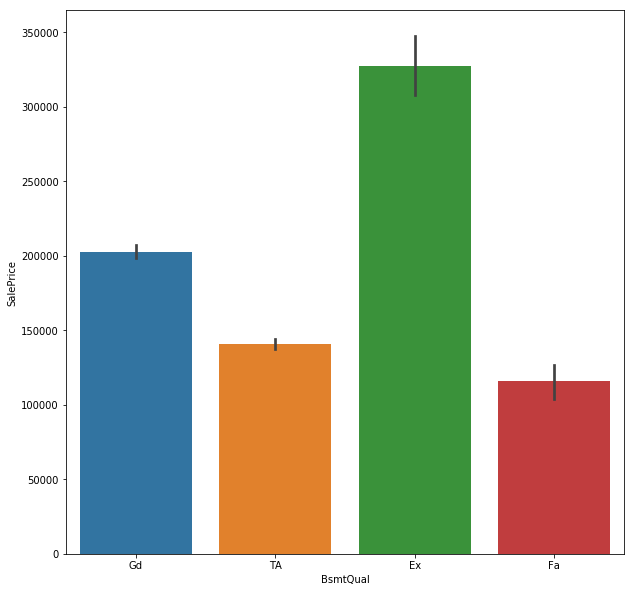

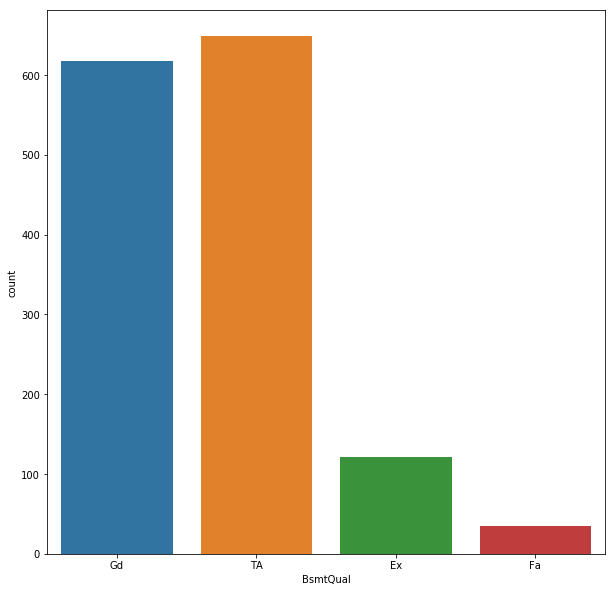

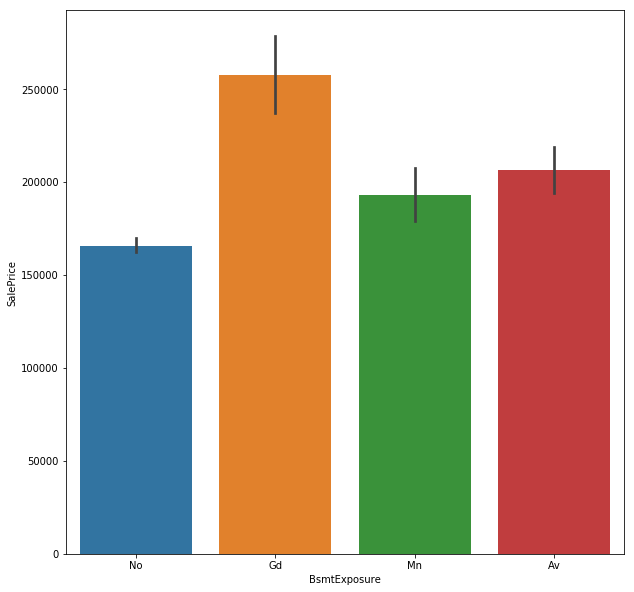

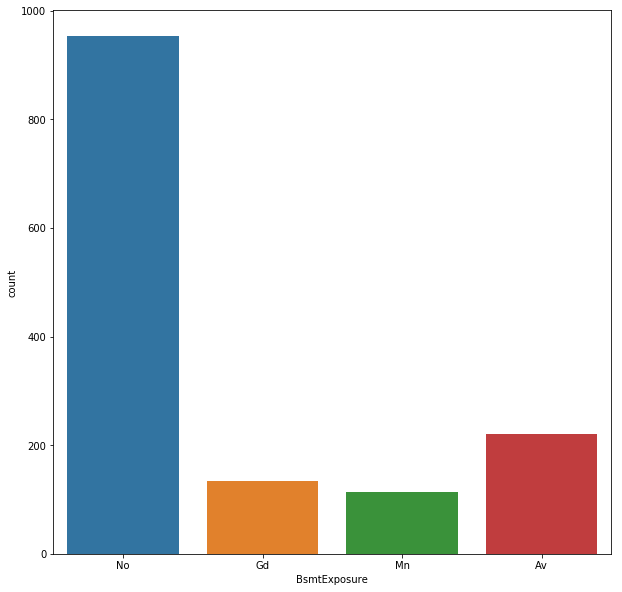

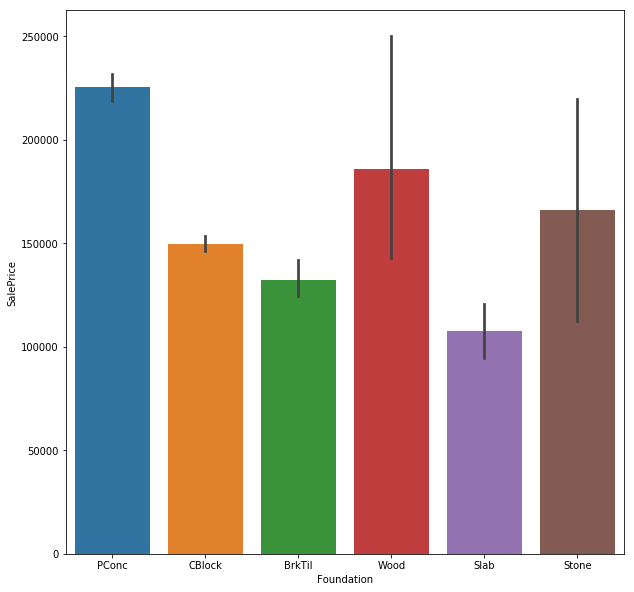

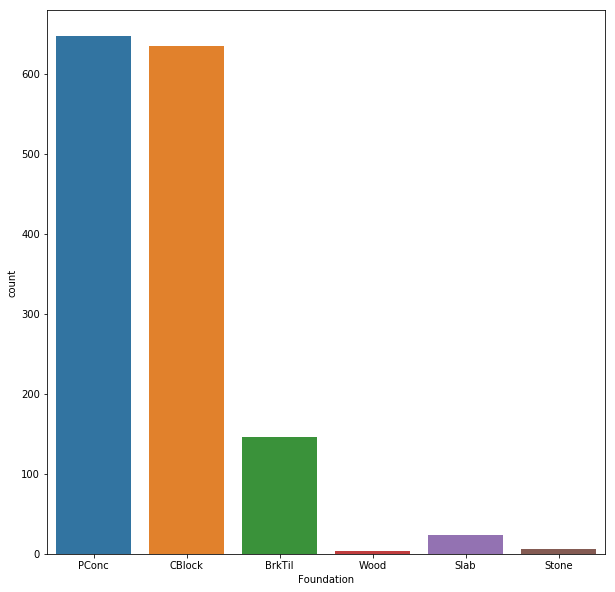

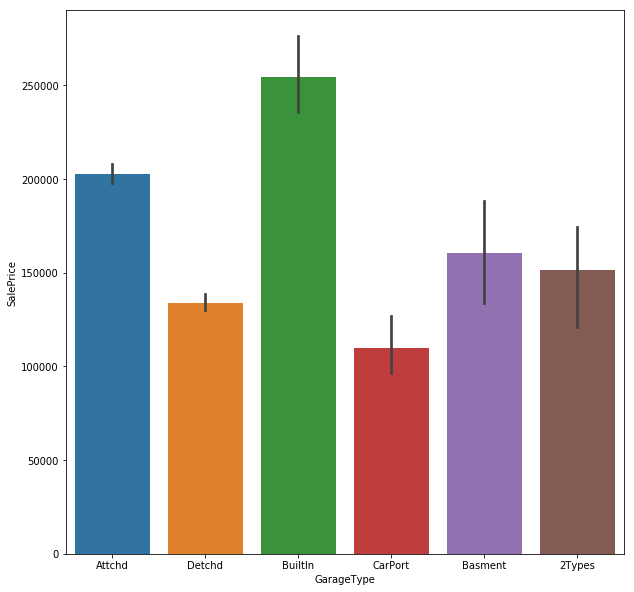

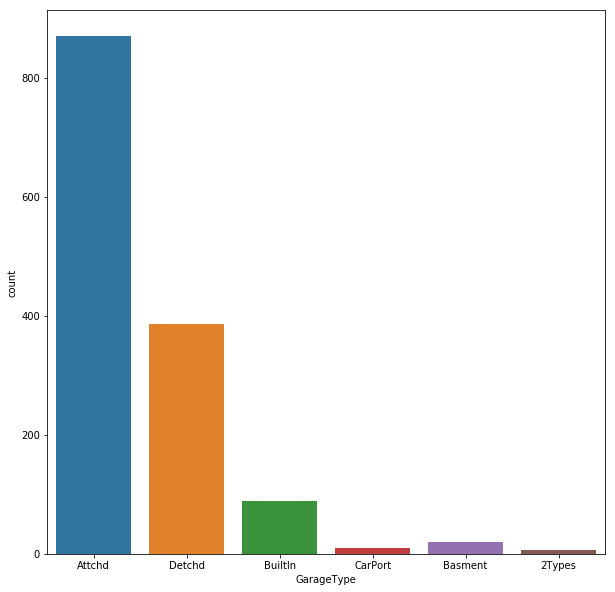

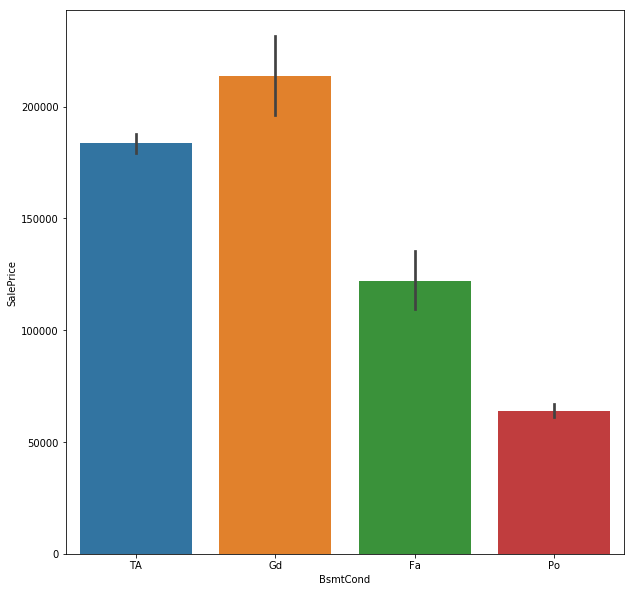

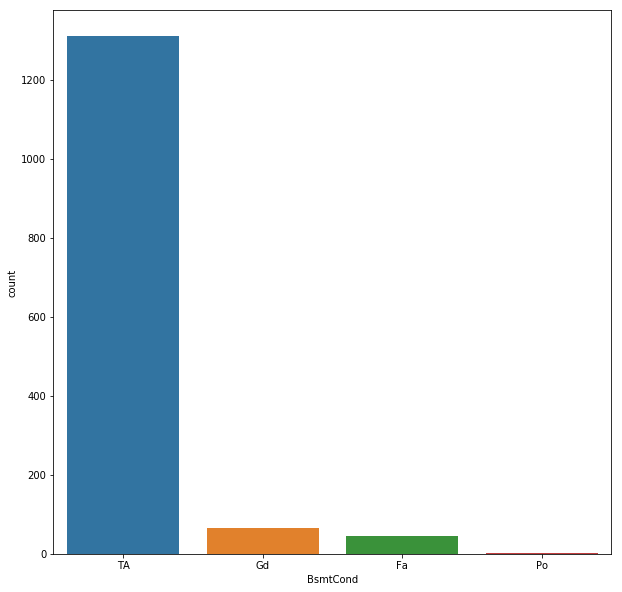

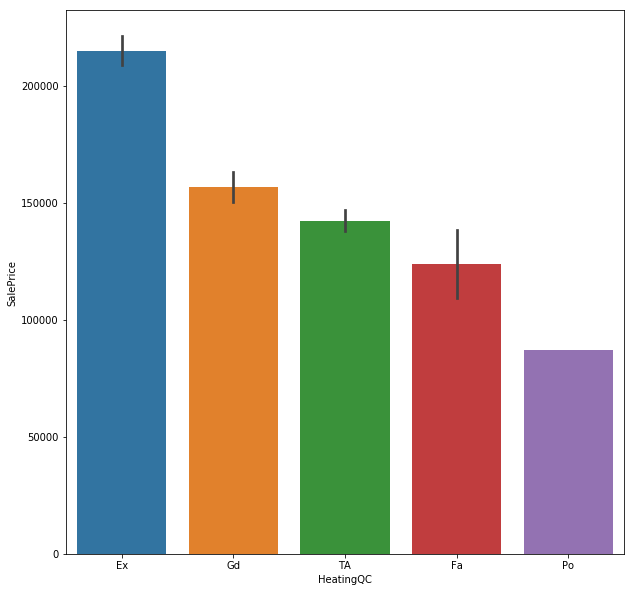

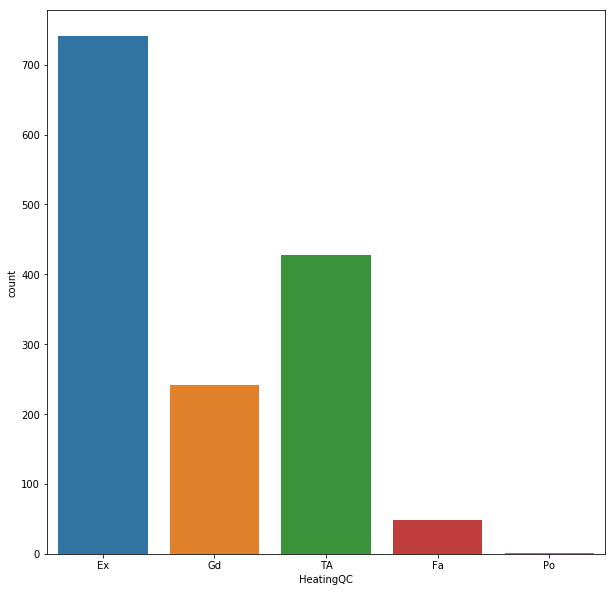

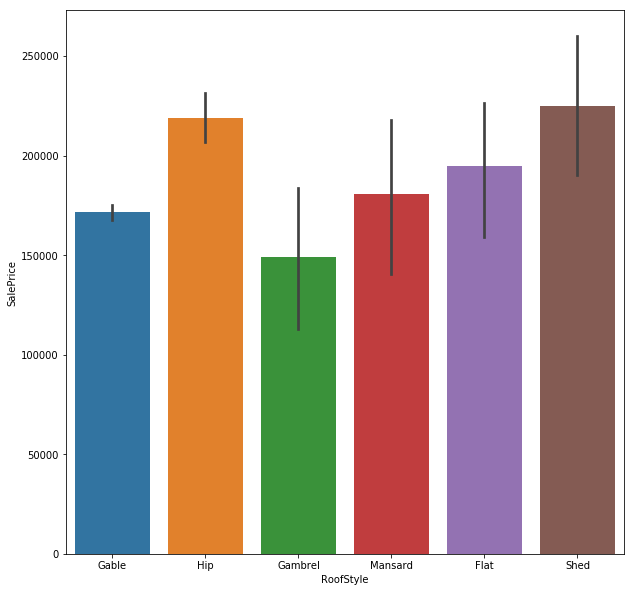

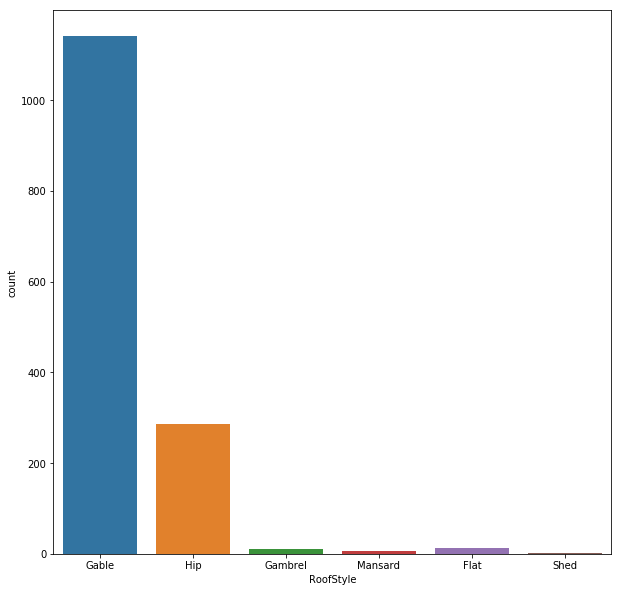

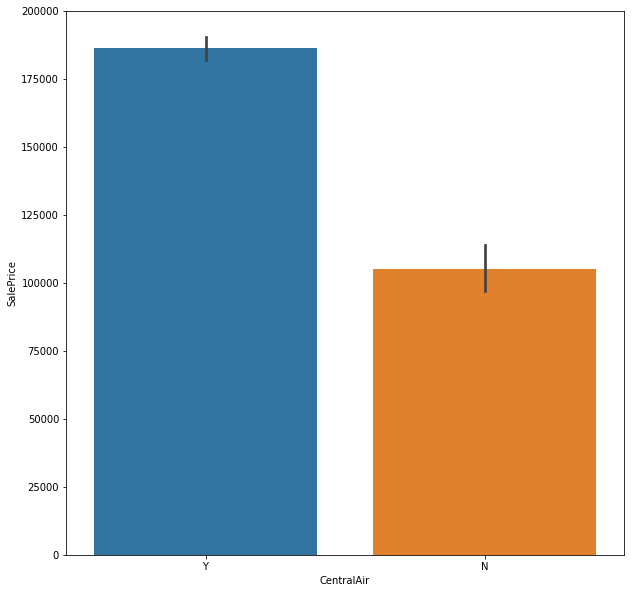

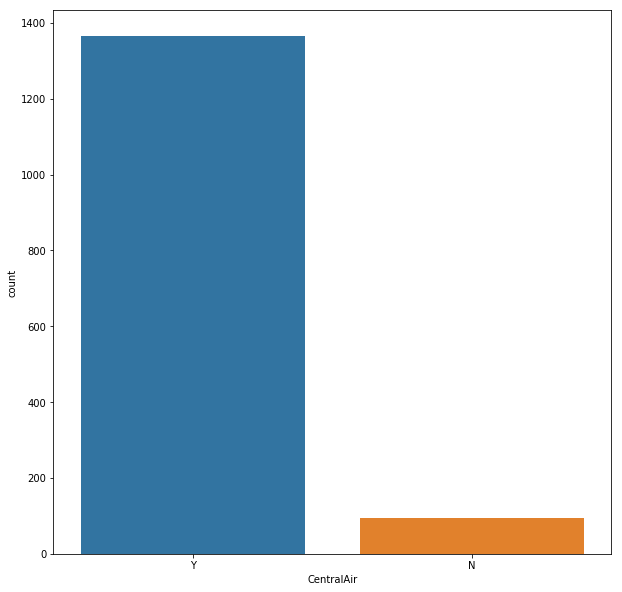

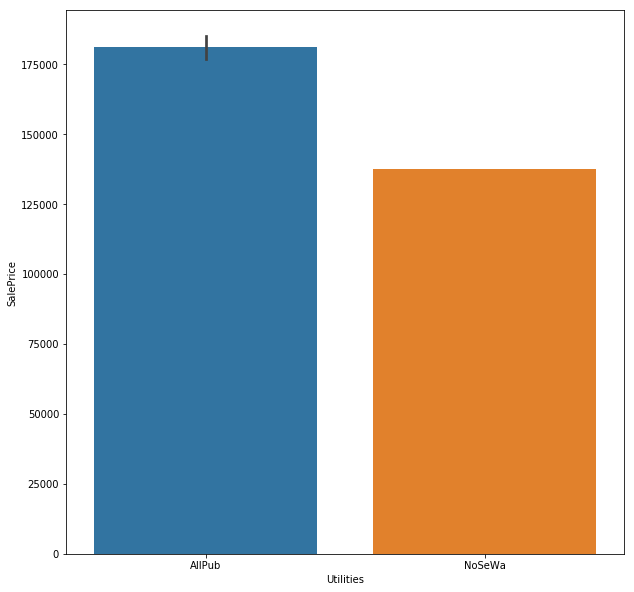

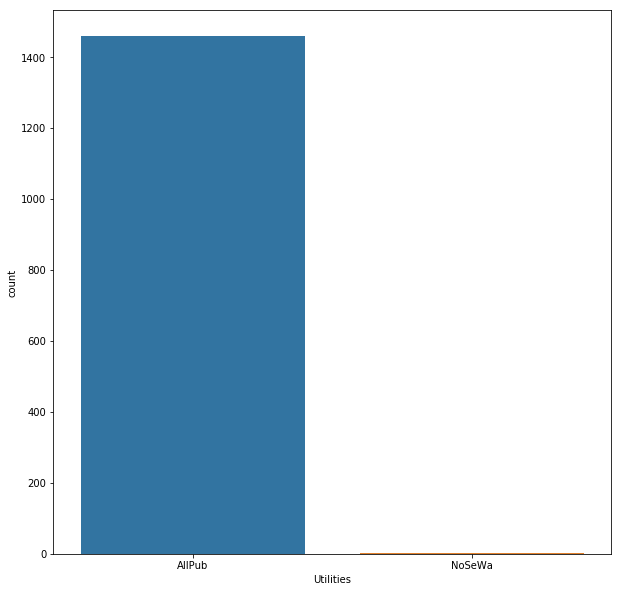

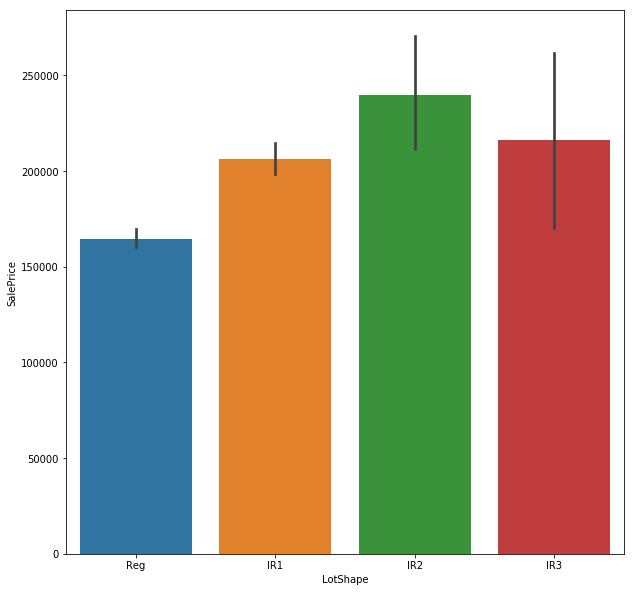

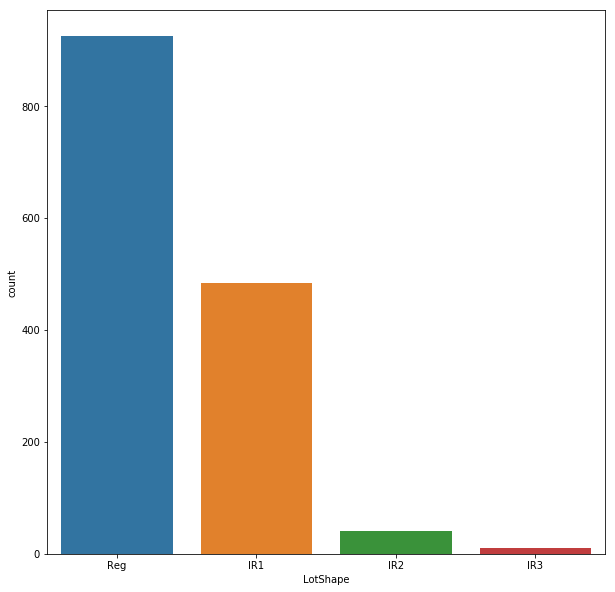

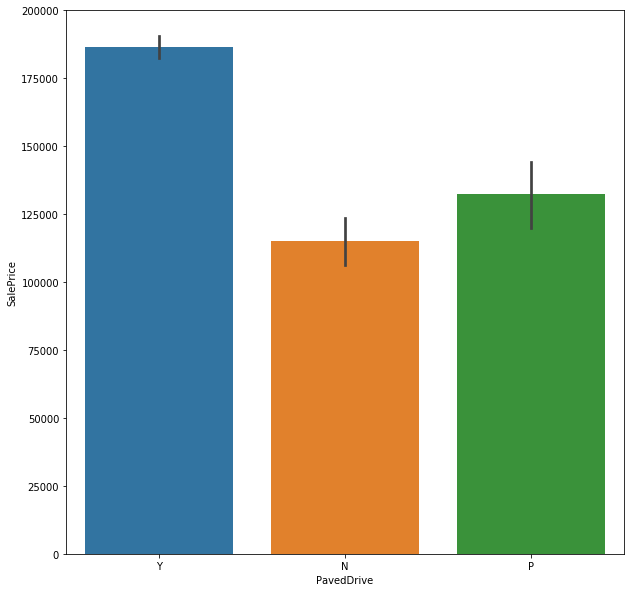

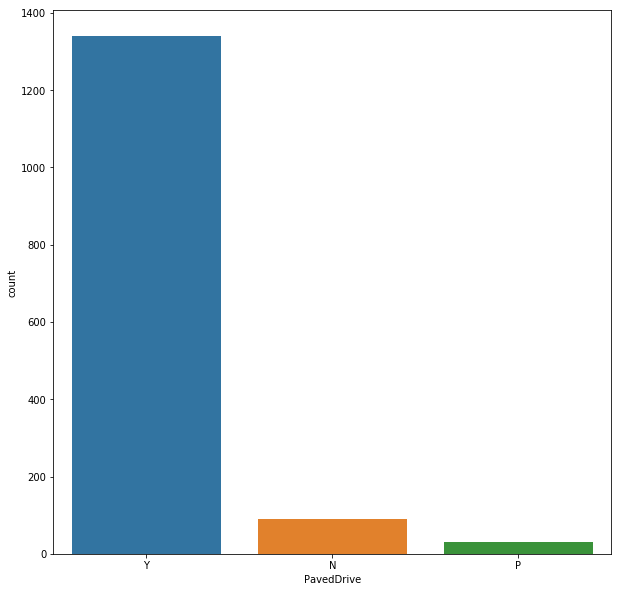

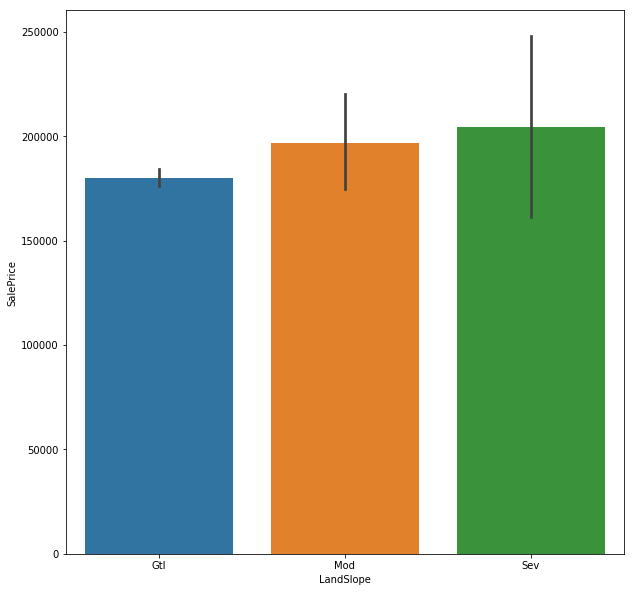

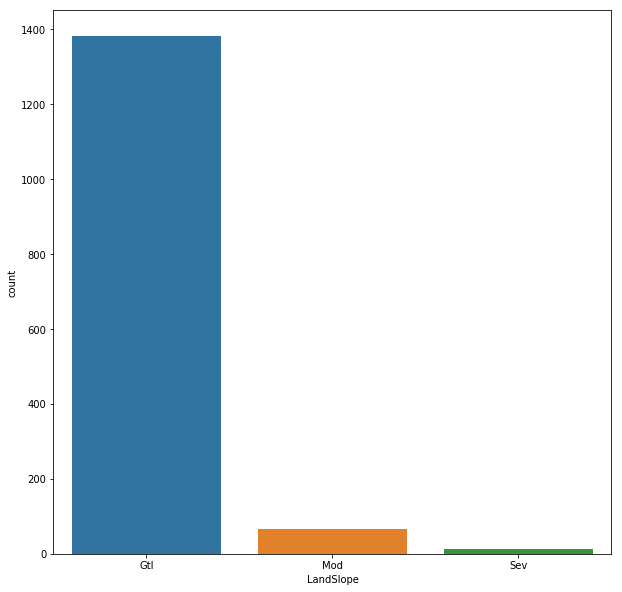

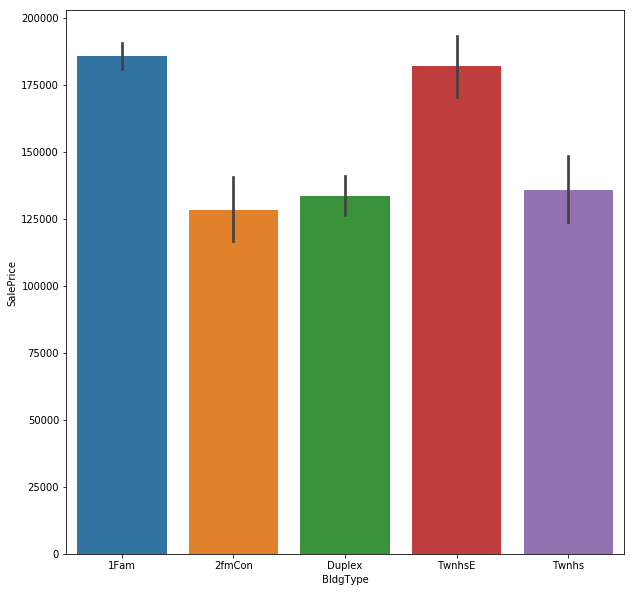

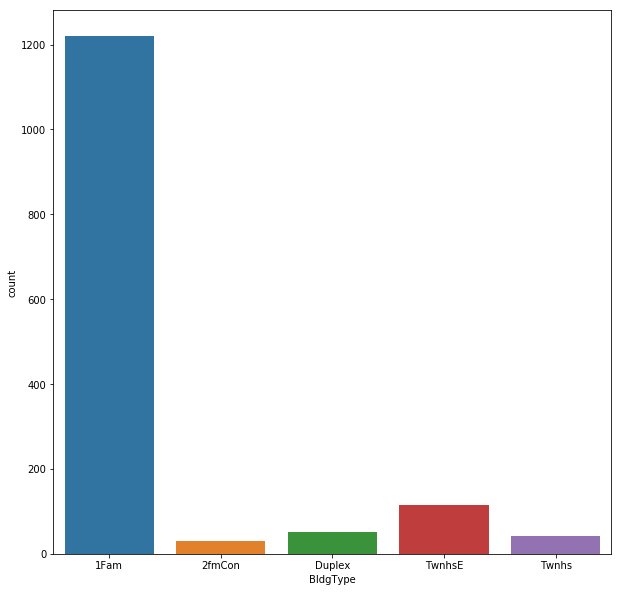

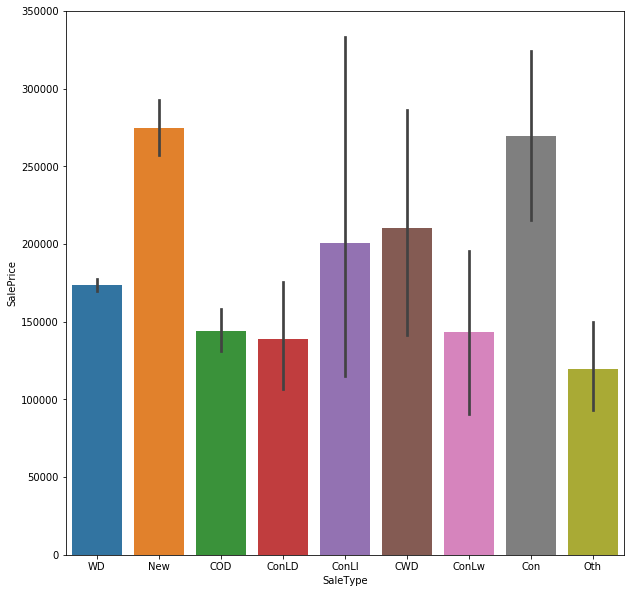

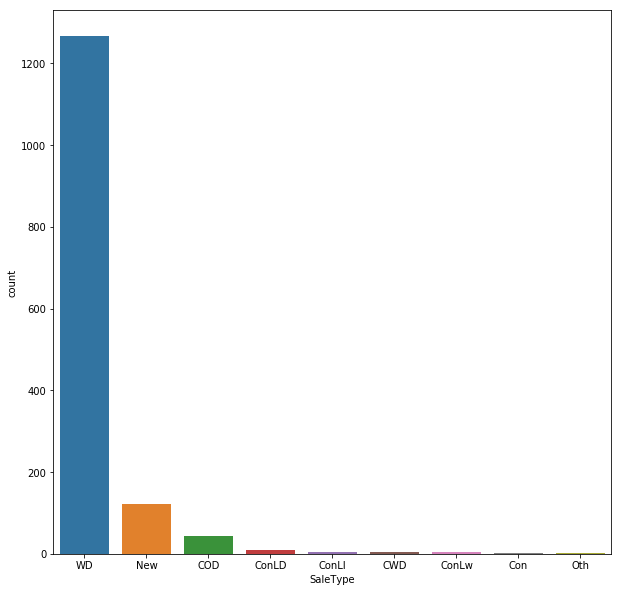

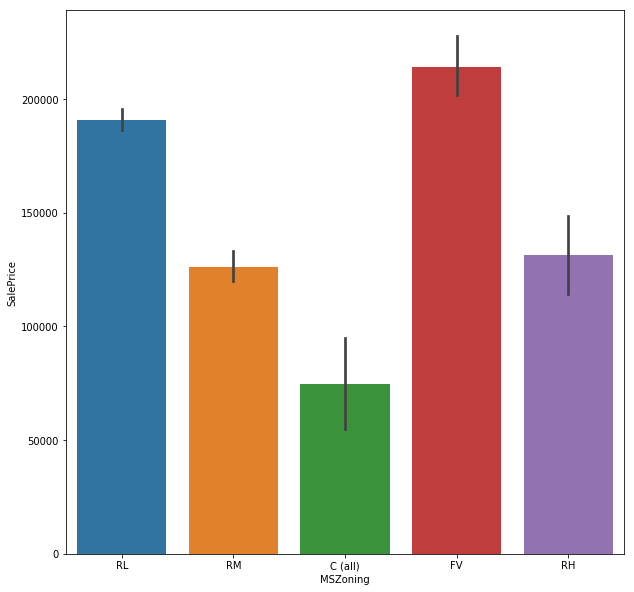

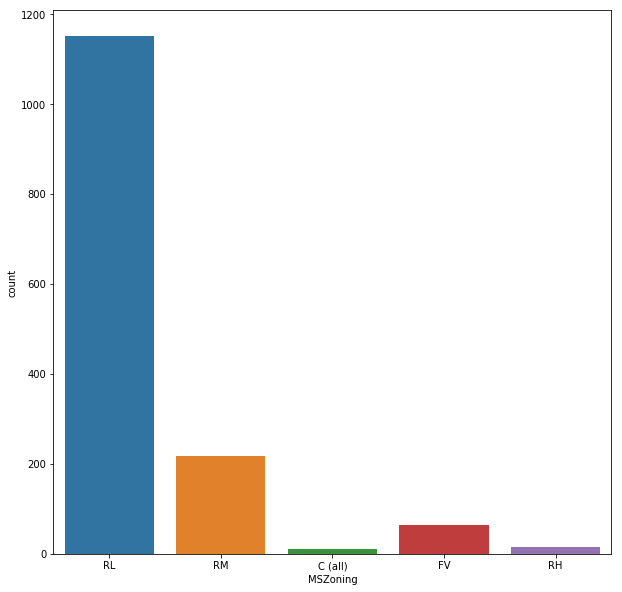

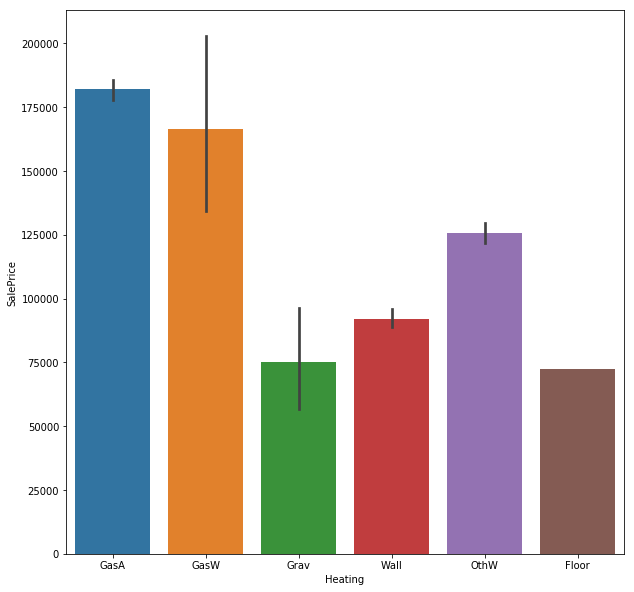

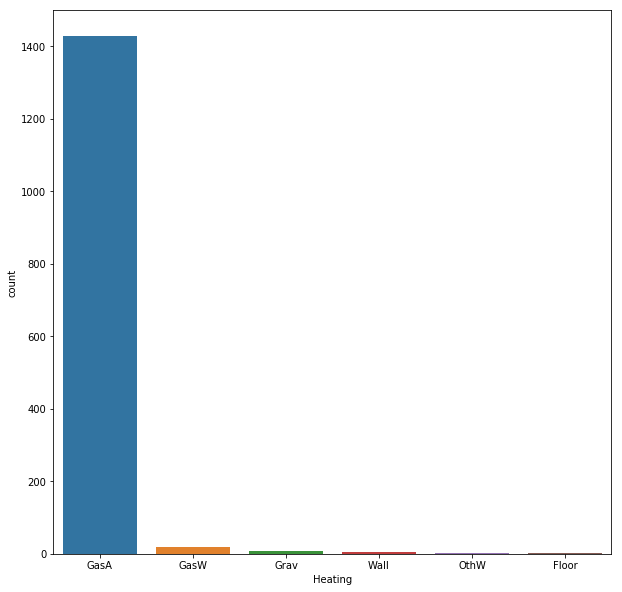

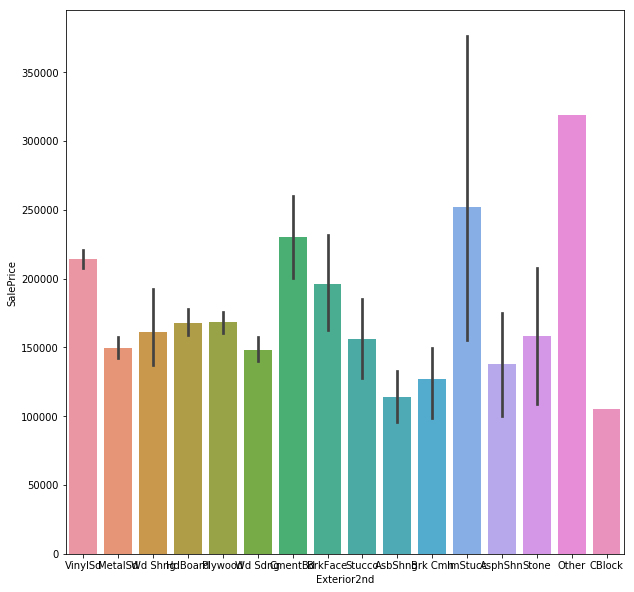

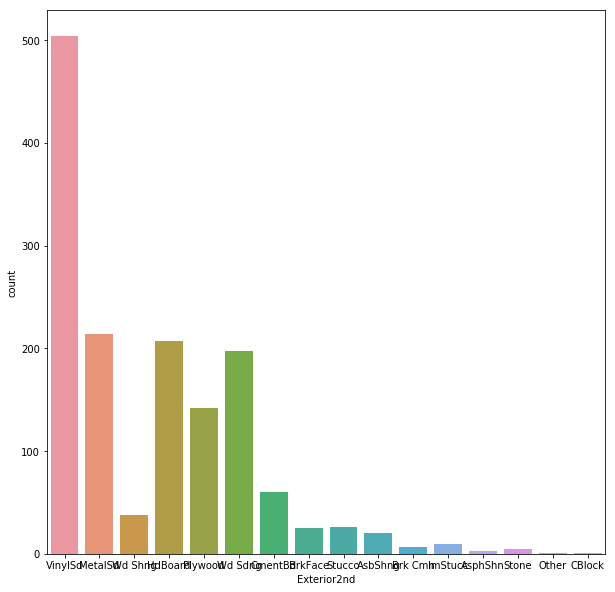

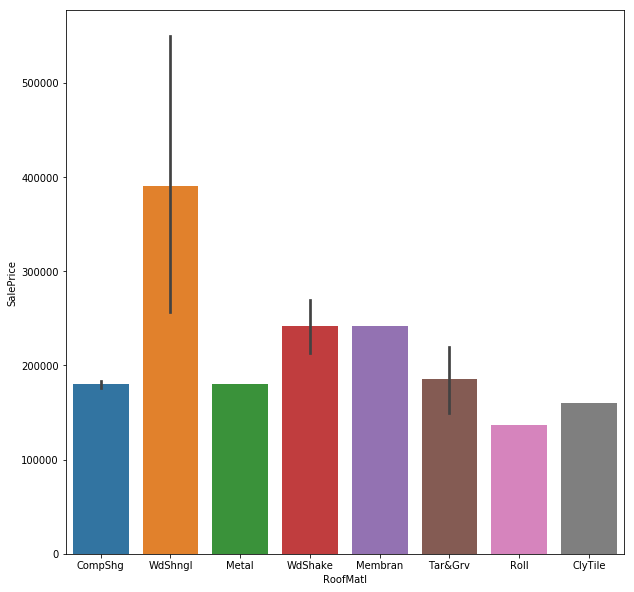

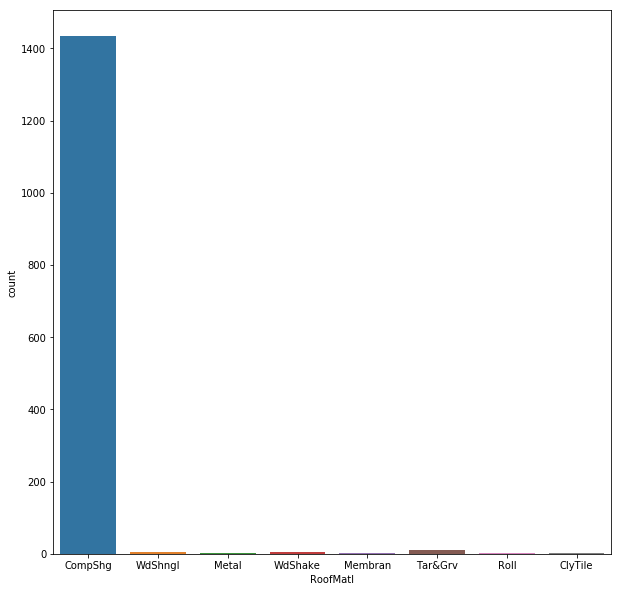

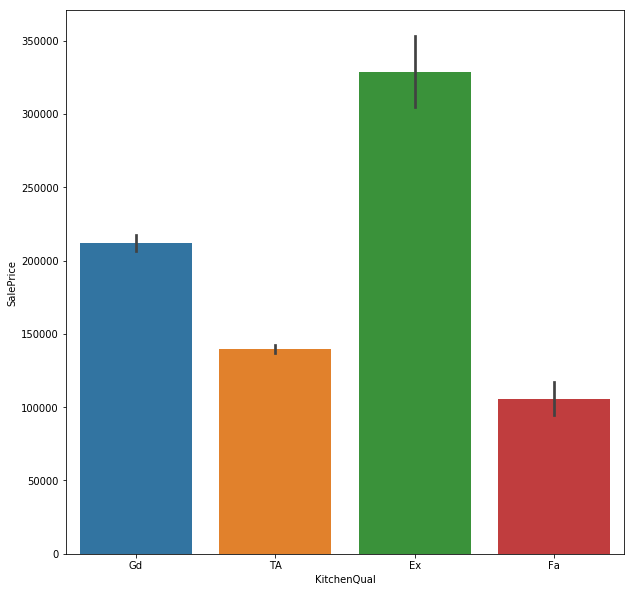

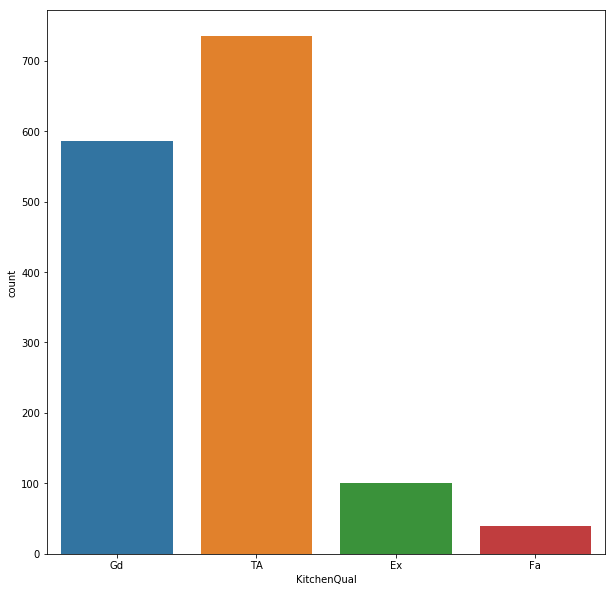

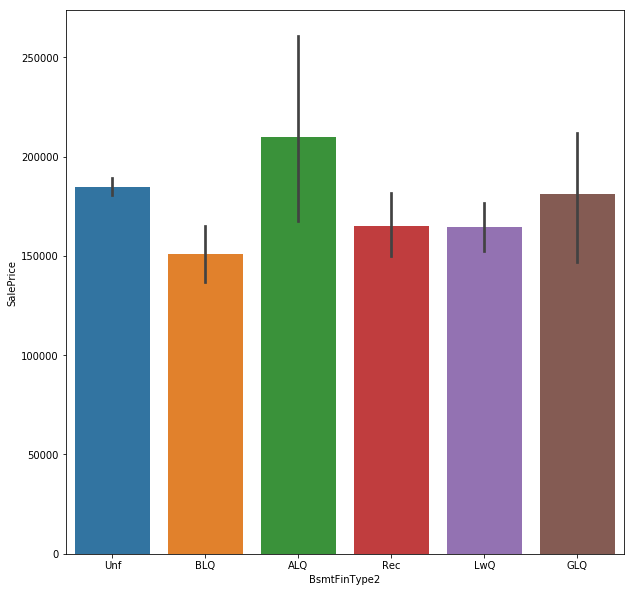

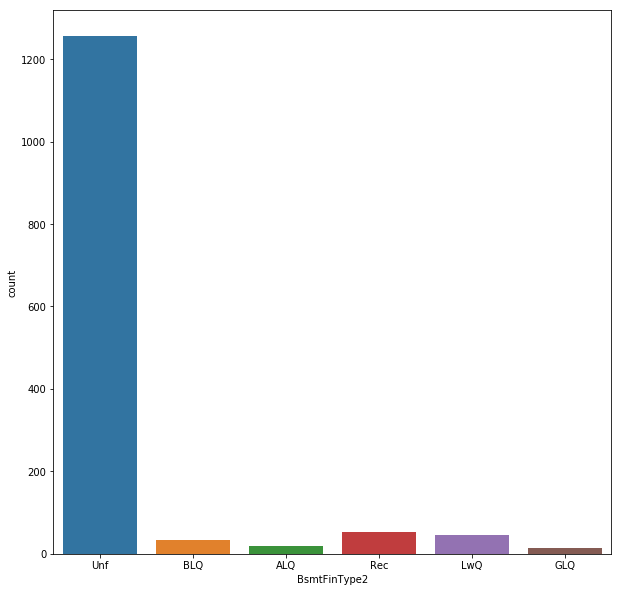

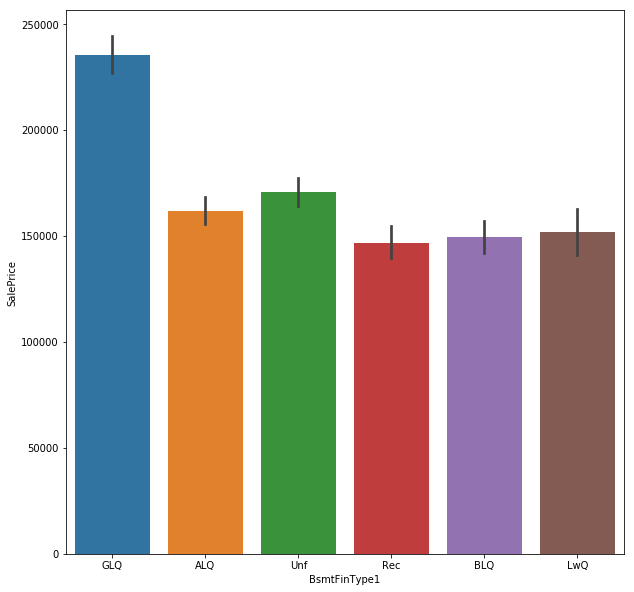

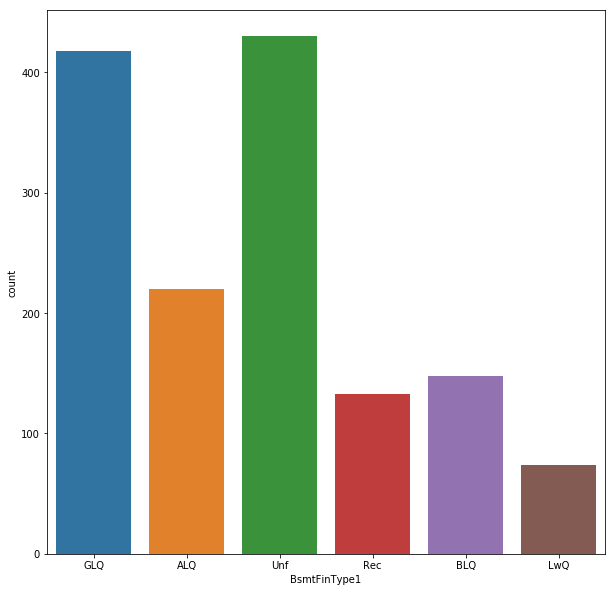

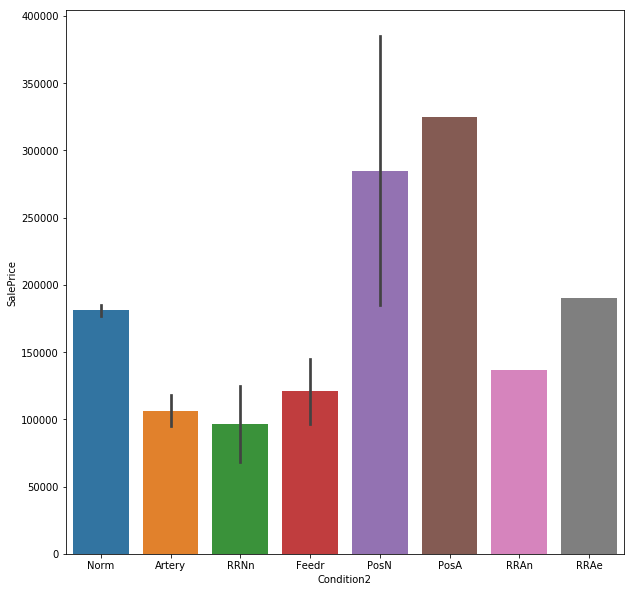

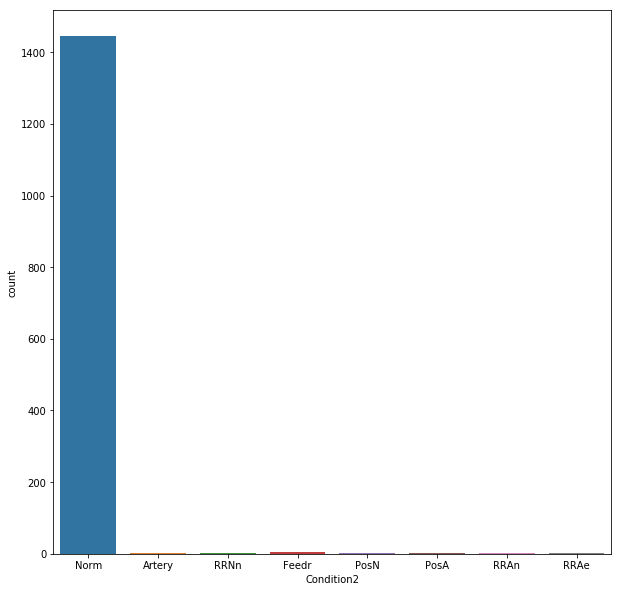

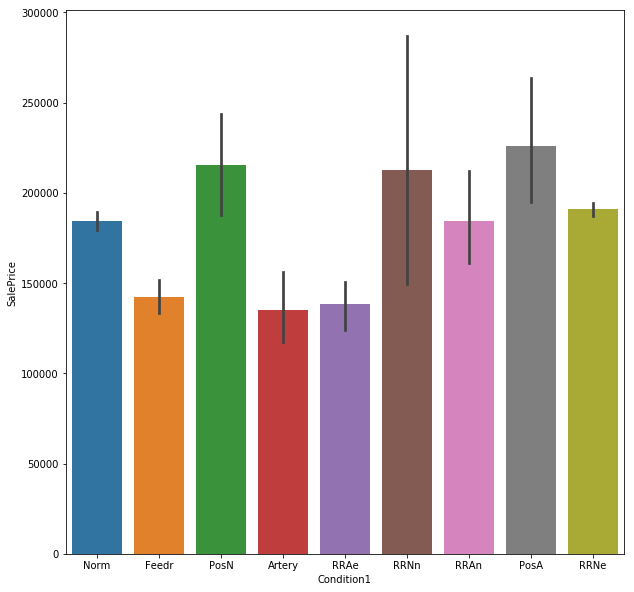

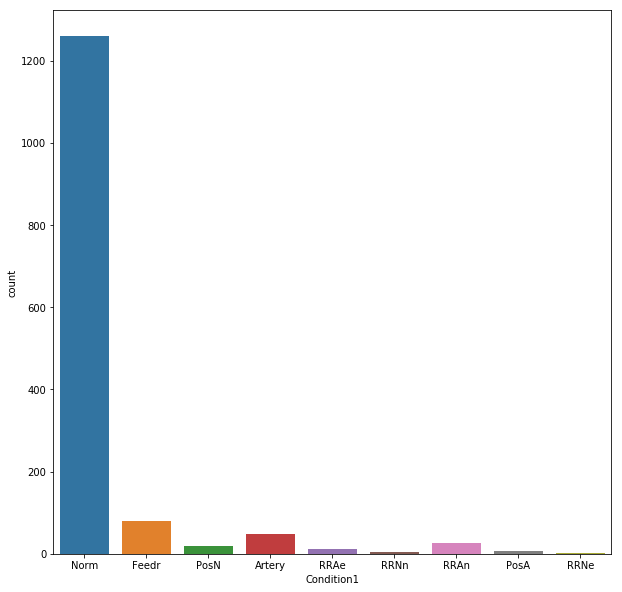

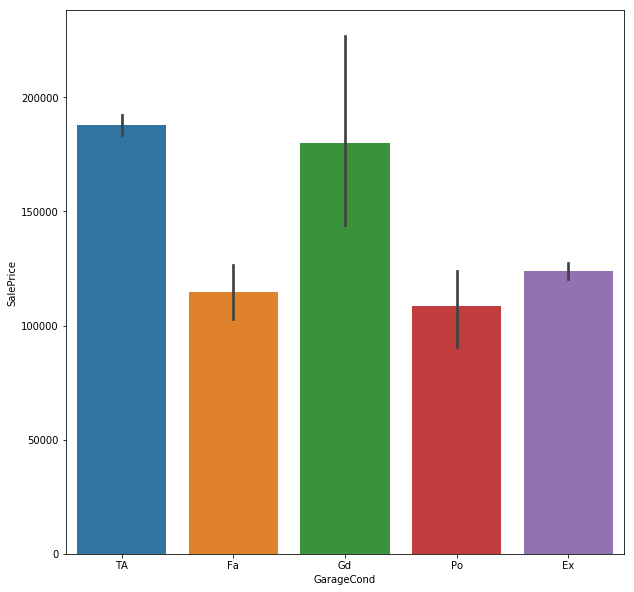

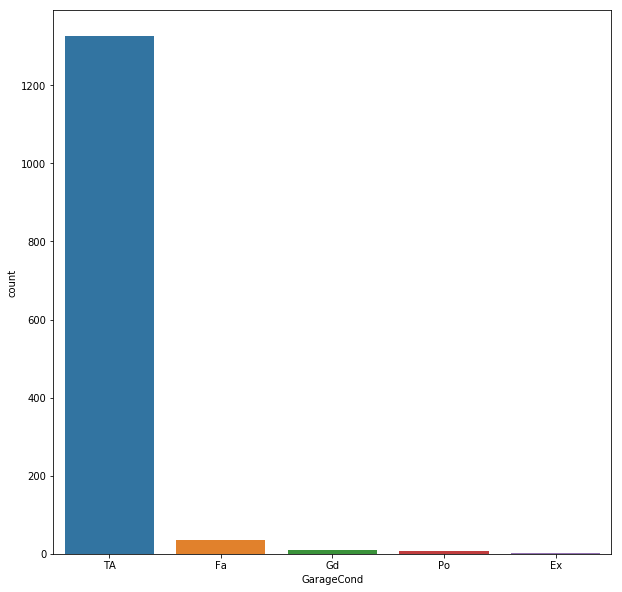

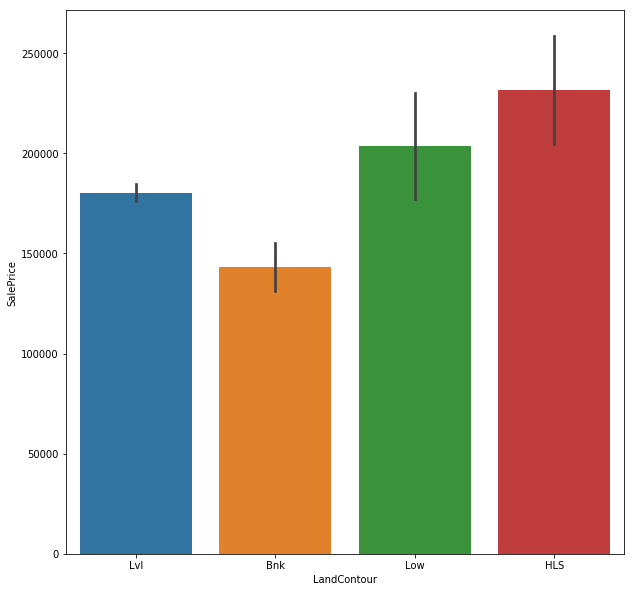

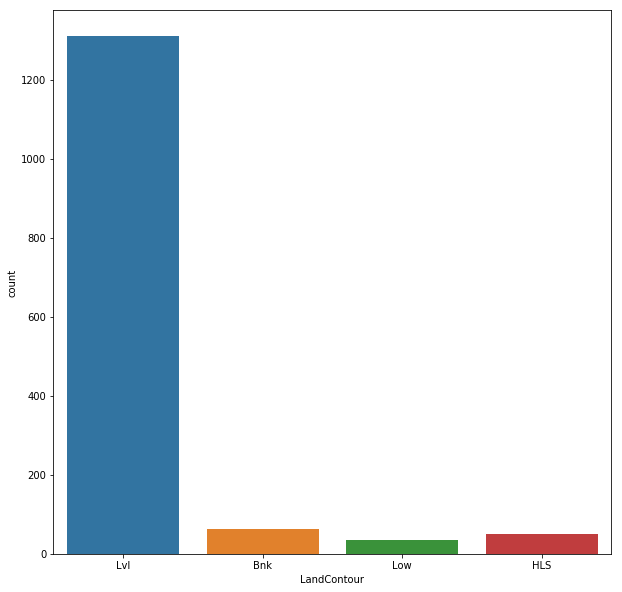

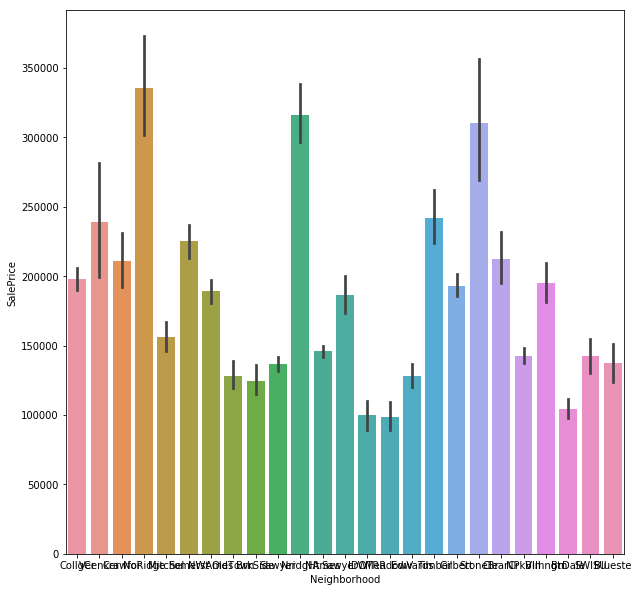

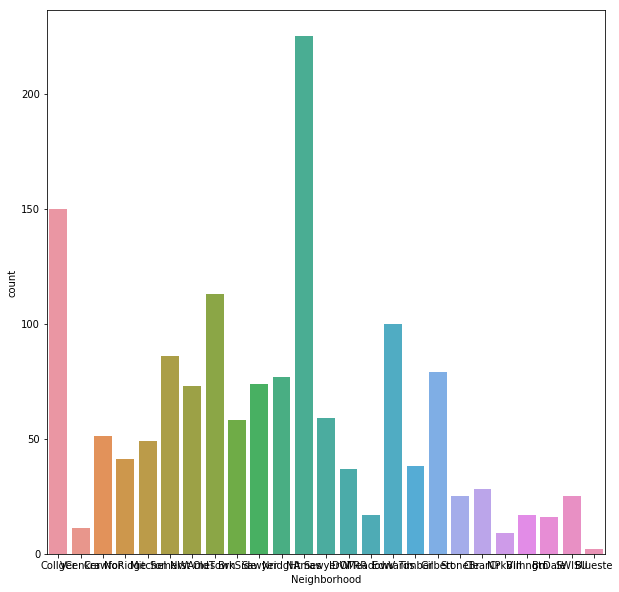

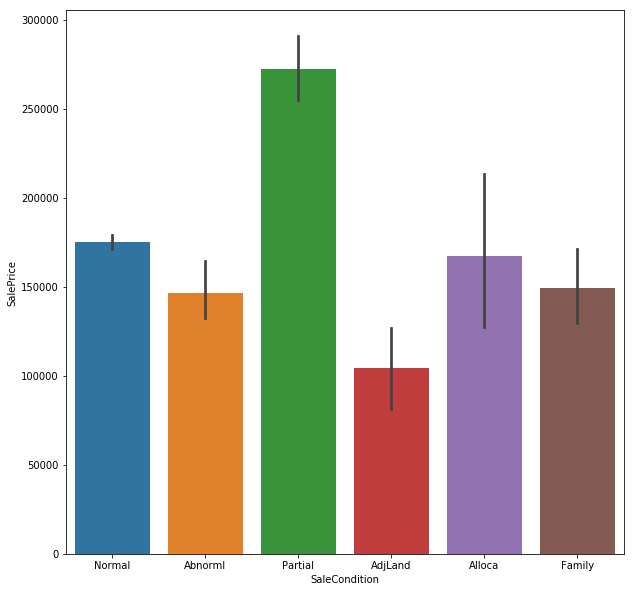

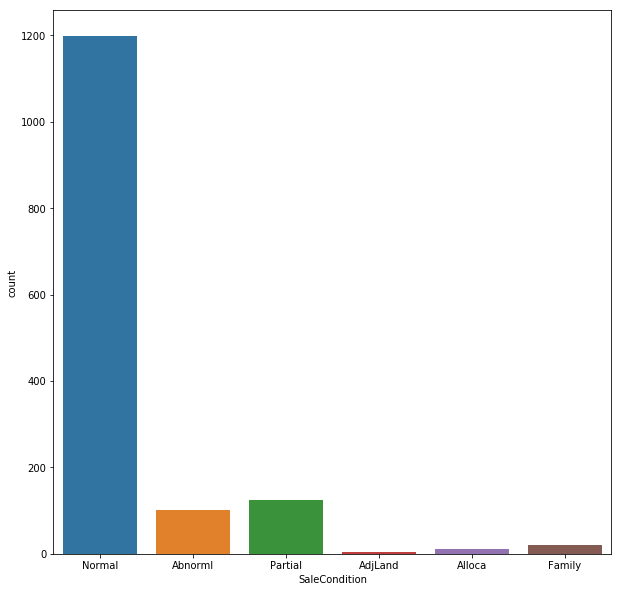

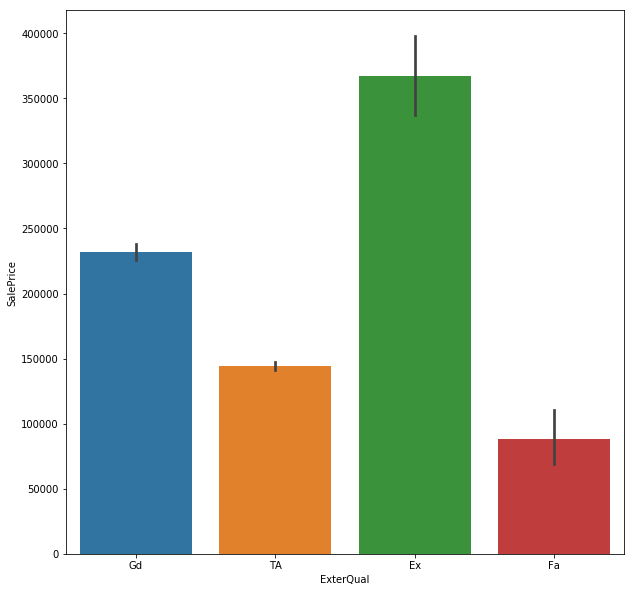

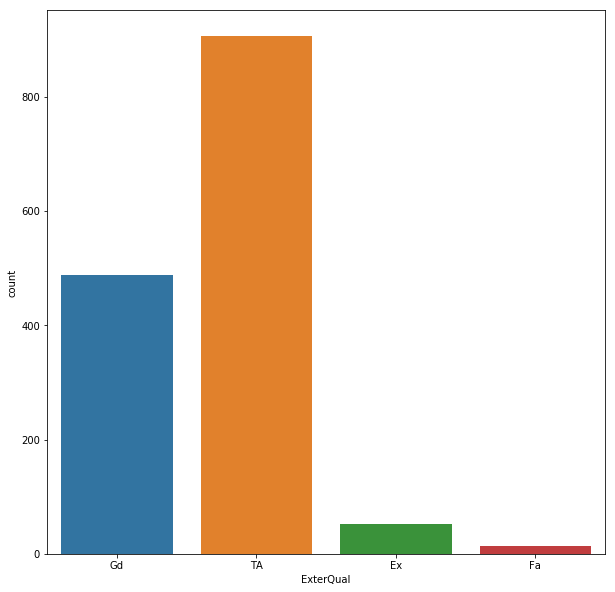

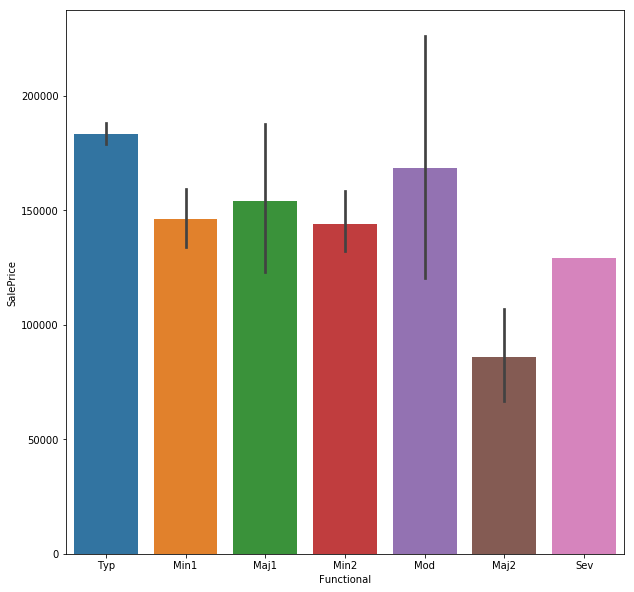

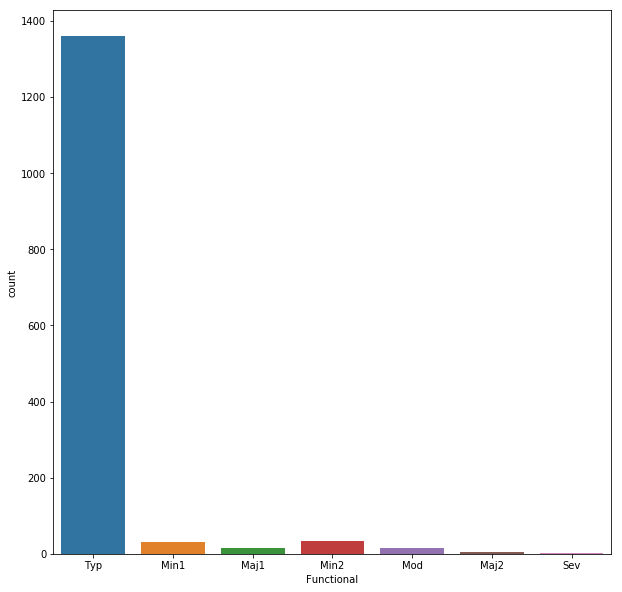

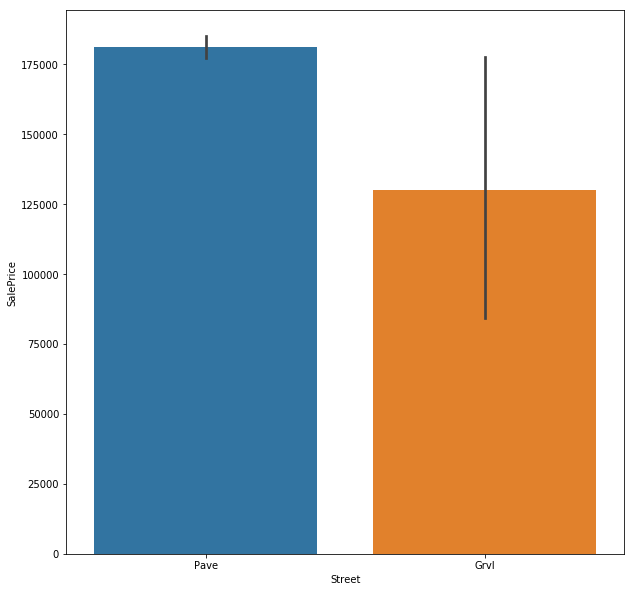

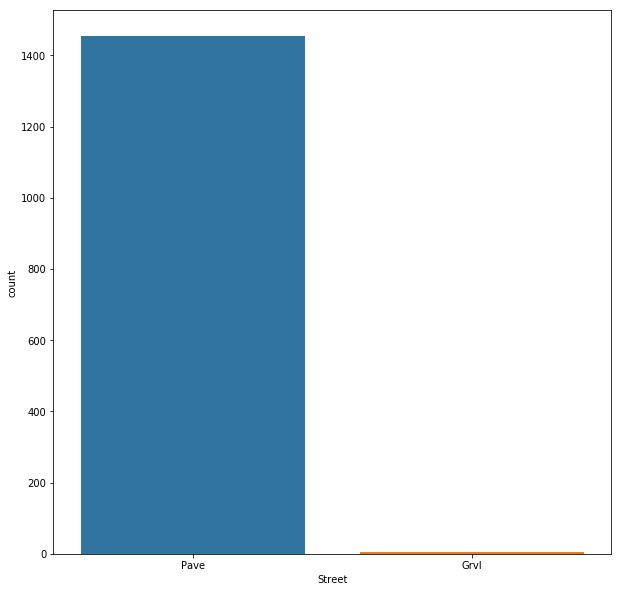

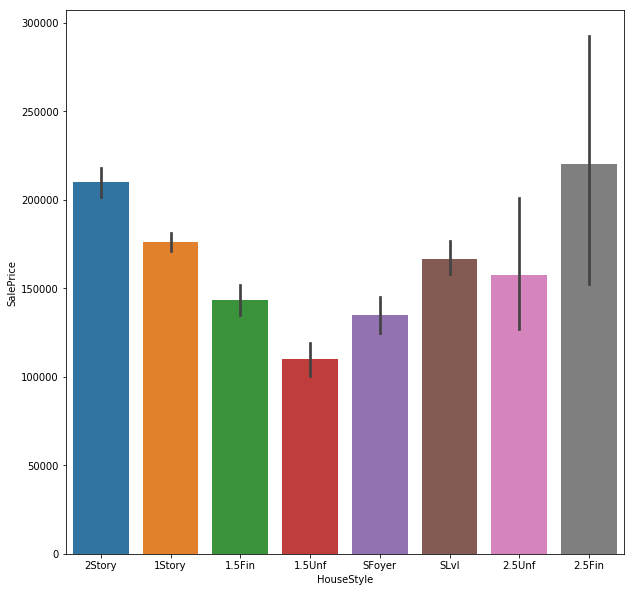

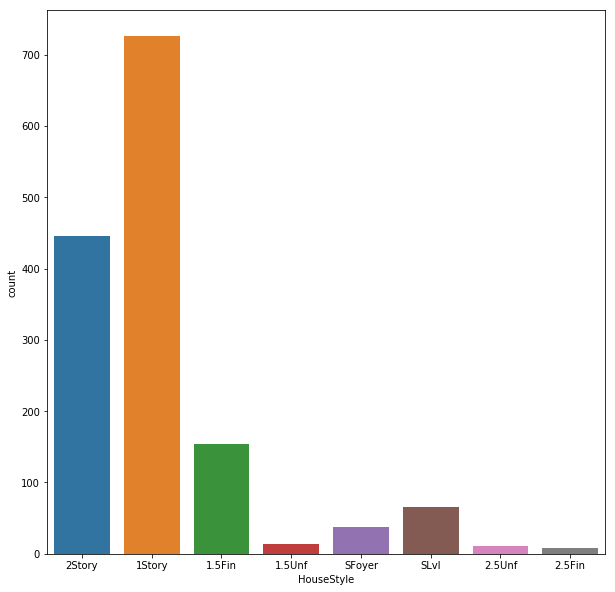

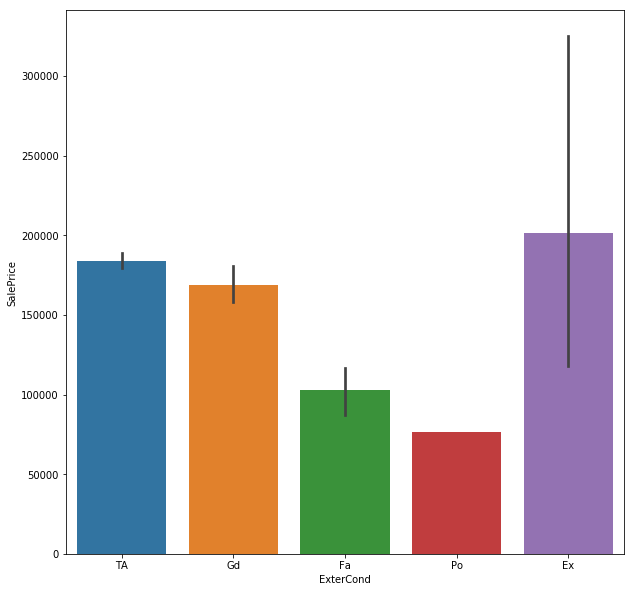

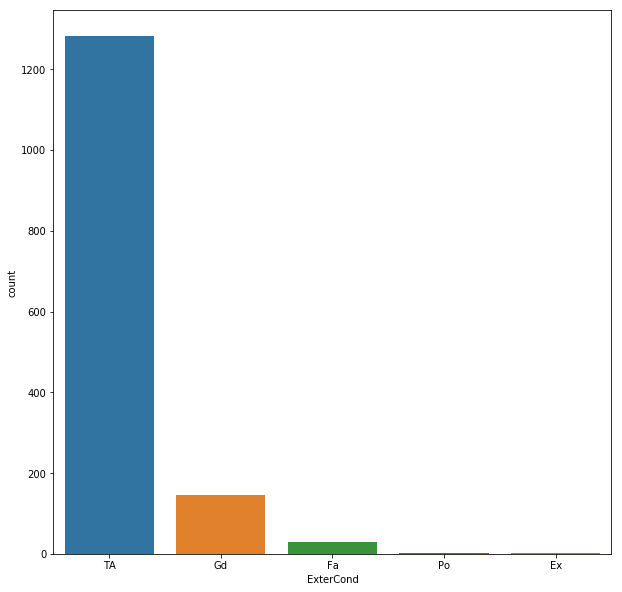

In [156]:
for i in categorical_columns:
    plot_things(i)

In [158]:
train_new["LotFrontage"].isnull().sum()
np.nanmean(train_new["LotFrontage"])

70.049958368026651

In [142]:
def clean(train,test):
    all_data=pd.concat([train.drop(["SalePrice","MiscFeature","Fence","PoolQC","FireplaceQu","Alley"],axis=1),test.drop(["MiscFeature","Fence","PoolQC","FireplaceQu","Alley"],axis=1)])
    return all_data[:len(train)],all_data[len(train):]

In [151]:
data_train,data_test=clean(train,test)
len(data_test)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 75 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-null object
Exterior2nd      1458 non

In [ ]:
 MSZoning LotFrontage Utilities Exterior1st Exterior2nd MasVnrType MasVnrArea BsmtQual BsmtCond BsmtExposure BsmtFinType1 
    BsmtFinType2 BsmtFinSF2 BsmtUnfSF TotalBsmtSF BsmtHalfBath BsmtFullBath KitchenQual Functional GarageType GarageYrBlt GarageFinish
    GarageCars GarageArea GarageQual GarageCond SaleType

In [71]:
correlation=train.corr()
correlation_with_target=correlation[["LotFrontage"]].drop("LotFrontage",axis=0)
correlation_with_target.sort_values(by="LotFrontage",ascending=False)

,LotFrontage
1stFlrSF,0.457181
LotArea,0.426095
GrLivArea,0.402797
TotalBsmtSF,0.392075
TotRmsAbvGrd,0.352096
SalePrice,0.351799
GarageArea,0.344997
GarageCars,0.285691
Fireplaces,0.266639
BedroomAbvGr,0.263170
